#### drive

In [21]:
!pip install git+https://github.com/logasja/lpips-pytorch.git

  Cloning https://github.com/logasja/lpips-pytorch.git to /tmp/pip-req-build-nahqe7n3
  Running command git clone --filter=blob:none --quiet https://github.com/logasja/lpips-pytorch.git /tmp/pip-req-build-nahqe7n3
  Resolved https://github.com/logasja/lpips-pytorch.git to commit 9aba7332ecab9c9af34b9787e5b40962f962f995
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for lpips-pytorch: filename=lpips_pytorch-0.0.1-py3-none-any.whl size=4947 sha256=e31494d48d1e0f671c8534b660262c919d27165fcb4438f0a1d61c89f6d357b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4fkbsyh/wheels/1c/c3/93/de67e6cefaf949932ed82d083aacf73879a38a6dbb1b6228e5
Successfully built lpips-pytorch


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### unet unconditional

In [1]:
import torch
import torch.nn as nn
import numpy as np

def sinusoidal_embedding(n, d):
    # n - размерность исходных данных (в нашем случае число моментов времени)
    # d - выходная размерность
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]) # коэффициенты для d гармоник
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1)).float()
    emb = t @ wk
    embedding = torch.cat((torch.sin(emb[:, :d//2]), torch.cos(emb[:, d//2:])), dim=1)
    # заполните половину из d компонент синунами sin(wk*t), оставшуюся косинусами cos(wk*t), где wk - коэффициенты гармоник
    return embedding

class ResBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, n_gr=8, drop=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_gr, cin)
        self.act1 = nn.Sigmoid()
        self.conv1 = nn.Conv2d(cin, cout, kernel_size=(3, 3), padding=(1, 1))
        self.time_fc = nn.Linear(time_ch, cin)
        self.time_act = nn.Sigmoid()
        self.c = [cin, cout, time_ch]

    def forward(self, x, time):
        y = self.time_fc(time * self.time_act(time))[:, :, None, None]
        x += y
        out = self.norm1(x)
        out = self.conv1(out * self.act1(out))
        return out

class Attention(nn.Module):
    def __init__(self, cin, heads=1, d = None, n_gr=8):
        super().__init__()
        if d is None:
            d = cin
        self.norm = nn.GroupNorm(n_gr, cin)
        self.fc = nn.Linear(cin, heads * d * 3)
        self.last_fc = nn.Linear(heads * d, cin)
        self.scale = d ** -0.5
        self.heads = heads
        self.d = d

    def forward(self, x, t=None):
        bs, cin, h, w = x.shape
        x = x.reshape(bs, cin, -1).permute(0, 2, 1)
        qkv = self.fc(x).reshape(bs, -1, self.heads, 3 * self.d)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        out = torch.einsum('bijh,bjhd->bihd', attn, v).reshape(bs, -1, self.heads * self.d)
        out = self.last_fc(out) + x
        out = out.permute(0, 2, 1).reshape(bs, cin, h, w)
        return out

class UpBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res_blk = ResBlock(cin+cout, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
         return self.attn(self.res_blk(x, t))

class Middle(nn.Module):
    def __init__(self, cout, ch):
        super().__init__()
        self.res1 = ResBlock(cout, cout, ch)
        self.attn = Attention(cout)
        self.res2 = ResBlock(cout, cout, ch)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x, t)
        x = self.res2(x, t)
        return x

class DownBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res = ResBlock(cin, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()
    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=16):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim * 4)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim * 4)
        self.time_embed.requires_grad_(False) # мы эмбединг слой уже инициализировали и менять его не будем

        cout, cin, ch = [time_emb_dim]*3
        B = 1
        res = [1, 2, 2]
        has_attn = [False, False, True, True]
        self.conv1 = nn.Conv2d(3, ch, kernel_size=(3, 3), padding=(1, 1))
        down = []
        for i in range(len(res)):
          cout = cin * res[i]
          for _ in range(B):
            down.append(DownBlock(cin,cout, ch * 4, has_attn[i]))
            cin = cout
          if i < len(res) - 1:
            down.append(nn.Conv2d(cin, cin, (3, 3), (2, 2), (1, 1)))
        self.down = nn.ModuleList(down)
        self.middle = Middle(cout, ch*4)
        up = []
        cin = cout
        for i in range(len(res)-1, -1, -1):
            cout = cin
            for _ in range(B):
              up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cout = cin // res[i]
            up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cin = cout
            if i > 0:
              up.append(nn.ConvTranspose2d(cin, cin, (4, 4), (2, 2), (1, 1)))
        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, ch)
        self.act = nn.Sigmoid()
        self.last = nn.Conv2d(cin, 3, kernel_size=(3, 3), padding=(1, 1))


    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, x, time):
        t = self.time_embed(time)
        x = self.conv1(x)
        lst = [x]
        for layer in self.down:
            if isinstance(layer, nn.Conv2d):
              x = layer(x)
            else:
              x = layer(x, t)
            lst.append(x)
        x = self.middle(x, t)
        for layer in self.up:
            if isinstance(layer, nn.ConvTranspose2d):
                x = layer(x)
            else:
                connection = lst.pop()
                x = torch.cat((x, connection), dim=1)
                x = layer(x, t)
        x = self.norm(x)
        x = self.last(x * self.act(x))
        return x

#### ddpm unconditional

In [2]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self,
                 network,  # UNet2DModel instance
                 n_steps=1000,
                 min_beta=1e-4,
                 max_beta=1e-2,
                 device=None,
                 image_chw=(3, 32, 32),  # default image size, you can change this
                 scheduler_params=None):

        super().__init__()
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)

        # Initialize scheduler parameters
        if scheduler_params is not None:
            self.n_T = scheduler_params.num_train_timesteps
            self.betas = torch.linspace(scheduler_params.beta_start, scheduler_params.beta_end, self.n_T).to(device)
            self.alphas = (1 - self.betas)
            self.alpha_bars = (1 - self.betas).cumprod(axis=0)
        else:
            # Default initialization if scheduler_params is not provided
            self.n_T = n_steps
            self.betas = torch.linspace(min_beta, max_beta, self.n_T).to(device)
            self.alphas = (1 - self.betas)
            self.alpha_bars = (1 - self.betas).cumprod(axis=0)

    def forward(self, x0, t, eta=None):
        # Прямой проход диффузии (детерменированный марковский процесс)
        # :param x0 - исходная картинка (тензор формы [B,C,H,W])
        # :param t - шаг зашумления (тензор формы [B,1])
        # :param eta - \epsilon_t - добавочный шум на шаге зашумления t (тензор формы [B,C,H,W])

        if eta is None:
            eta = torch.randn_like(x0) # если шум не определен - инициализируйте его гауссом N(0,1) сами
        alpha_t = self.alpha_bars[t][:, None, None, None]
        noised_x = x0 * (alpha_t ** 0.5) + eta * (1 - alpha_t) ** 0.5
        return noised_x

    def backward(self, x, t, guide_w=None):
        # Обратный процесс. Здесь вам предстоит восстановить добавочный шум eta из зашумлённой картинки x на шаге t нейросетью
        # print("backward x, t, guide_w ->", x.shape, t.shape)
        if isinstance(self.network, UNet2DModel):
            eta_pred = self.network(sample=x, timestep=t).sample
            # print("backward UNet2DModel ->", eta_pred.shape, type(eta_pred))
        else:
            eta_pred = self.network(x, t)
            # print("backward UNet ->", eta_pred.shape, type(eta_pred))
        return eta_pred

    def sample(self, n_samples, size, x=None, guide_w=None):
      # Starting from random noise
      c, h, w = size
      if x is None:
        x = torch.randn([n_samples, c, h, w]).to(self.device) # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])

      for idx, t in enumerate(range(self.n_T-1, -1, -1)): # Денойзим наши картинки для каждого шага, начиная с последнего
          # Estimating noise to be removed
          time_tensor =  torch.tensor([t]*n_samples).reshape(-1, 1).long().to(device)  # [n_samples, 1].long()
          eta_theta = self.backward(x, time_tensor.reshape(-1)) #  Предсказываем добавочный шум нейросетью

          alpha_t = self.alphas[time_tensor][:, :, None, None]
          alpha_t_bar = self.alpha_bars[time_tensor][:, :, None, None]
          beta_t = self.betas[time_tensor][:, :, None, None]
          alpha_t_m1_bar = self.alpha_bars[time_tensor-1][:, :, None, None]

          x = (x - (1 - alpha_t) / (1 - alpha_t_bar)**0.5 * eta_theta) / (alpha_t**0.5)  # Вычитаем добавочный шум из картинки
          if t > 0:
              z = torch.randn(n_samples, c, h, w).to(device)
              sigma_t = ((1-alpha_t_m1_bar) / (1-alpha_t_bar) * beta_t)**0.5 # определите сигму по любому из предлагаемых DDPM способов
              x = x + sigma_t * z
      return x

    def backward_dif(self, noise):
        n_sample = noise.shape[0]
        size = noise.shape[1:]
        device = noise.device
        x_i = self.sample(n_sample, size, x=noise)
        return x_i

    def compute_x0(self, x_t, timestep, guide_w=None):
        # computes x0 from x_t
        eps = self.backward(x_t, timestep)
        alpha_t = self.alpha_bars[timestep][:, None, None, None]
        x0 = (x_t - (1 - alpha_t) ** 0.5 * eps) / (alpha_t ** 0.5)
        return x0


### Downloading pretrained model from hugging face

In [3]:
!pip install diffusers["torch"] transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

### Training & testing part

#### dataloaders

In [23]:
import torch
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, path_noise, path_images, tf=None):
        self.noise = [os.path.join(path_noise, file_name) for file_name in sorted(os.listdir(path_noise))]
        self.images = [os.path.join(path_images, file_name) for file_name in sorted(os.listdir(path_images))]
        self.bs = torch.load(self.noise[0]).shape[0]
        assert len(self.noise) == len(self.images)

    def __getitem__(self, index):
        x = torch.load(self.noise[index // self.bs])[index % self.bs]
        y = torch.load(self.images[index // self.bs])[index % self.bs]
        return x, y

    def __len__(self):
        return len(self.noise)*self.bs


def make_ref_loader(path_noise, path_images, batch_size, tf=None):
    # paths to noise-image pairs
    # return: dataloader of noise-image pairs
    dataset = MyDataset(path_noise, path_images, tf)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    return loader


#### distillation

In [24]:
import torch
import torch.nn.functional as F
from lpips_pytorch import LPIPS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def distribution_matching_loss(mu_real, mu_fake, x, min_dm_step, max_dm_step,
                               bs, forward_diffusion, guide_w):
    # mu_real, mu_fake: denoising networks for real and fake distribution
    # x: fake sample generated by our one-step generator
    # min_dm_step, max_dm_step: timestep intervals for computing distribution matching loss
    # bs: batch size

    # random timesteps
    timestep = torch.randint(low=min_dm_step, high=max_dm_step, size=(bs,), device=device)
    # Diffuse generated sample by injecting noise
    # e.g. noise_x = x + noise * sigma_t (EDM)
    noisy_x = forward_diffusion(x, timestep)
    # denoise using real and fake denoiser
    with torch.no_grad():
        pred_fake_image = mu_fake.compute_x0(noisy_x, timestep, guide_w)
        pred_real_image = mu_real.compute_x0(noisy_x, timestep, guide_w)
    # The weighting_factor diverges slightly from our
    # paper’s equation, adapting to accomodate the mean
    # prediction scheme we use here.
    weighting_factor = torch.abs(x - pred_real_image).mean(dim=[1, 2, 3], keepdim=True)
    grad = (pred_fake_image - pred_real_image) / weighting_factor
    # the loss that would enforce above grad
    loss = F.mse_loss(x, (x - grad).detach()) * 0.5
    return loss


def denoising_loss(pred_fake_image, x):
    # pred_fake_image: denoised output by mu_fake on x_t
    # x: fake sample generated by our one-step generator
    # weight: weighting strategy(SNR+1/0.5ˆ2 for EDM, SNR for SDv1.5)
    #weight = 1  # TO DO: what is weight?
    loss = F.mse_loss(pred_fake_image,  x, reduction='mean')
    return loss


criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
).to(device)

#criterion = LPIPS().to(device)

global normalization_history
normalization_history = []

def normalize(x):
    # print('norm', torch.max(x), torch.min(x))
    #x = x.clamp(-1, 1)
    return x

def lpips(x, y):
    x = torch.nn.functional.upsample_bilinear(x, size=(224, 224))
    y = torch.nn.functional.upsample_bilinear(y, size=(224, 224))
    global normalization_history
    normalization_history.append((torch.max(x).item(), torch.min(x).item()))
    return criterion(normalize(x), normalize(y)) / x.shape[0]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 132MB/s]
Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth
1

#### display functions

In [ ]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

def display_sample(sample, caption=None):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])

    if caption is not None:
        display(caption)
    display(image_pil)

def display_samples(noise_images, images, rows=1):
    assert len(noise_images) == len(images), "Number of noise images and images must be the same"
    batch_size = len(noise_images)
    cols = 2
    rows = min(rows, batch_size)

    _, axes = plt.subplots(rows, cols, figsize=(5, 3*(rows)))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if j == 0:  # Noise image
                noise_img = noise_images[idx].cpu().numpy().transpose(1, 2, 0)
                extent = [0, 1, 0, 1]  # Set extent to cover entire subplot
                axes[i, j].imshow(np.clip((noise_img + 1.0) * 127.5 / 255.0, 0, 1), extent=extent, interpolation='nearest', clip_on=True)  # Clip the data
                axes[i, j].axis('off')
            else:  # Real image
                img = images[idx-1].cpu().numpy().transpose(1, 2, 0)
                extent = [0, img.shape[1], 0, img.shape[0]]
                axes[i, j].imshow((img + 1.0) * 127.5 / 255.0, extent=extent, vmin=0, vmax=1)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust space between subplots
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    plt.show()

#### training

In [39]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
#from distillation import denoising_loss, distribution_matching_loss


def save_checkpoints(epoch, save_dir, netG, mu_fake, optimG, optimMuFake):
    torch.save({'epoch': epoch,
                'netG': netG.state_dict(),
                'mu_fake': mu_fake.state_dict(),
                'optimG': optimG.state_dict(),
                'optimMuFake': optimMuFake.state_dict()}, save_dir)


def load_checkpoints(resume, netG, mu_fake, optimG, optimMuFake):
    checkpoint = torch.load(resume)
    netG.load_state_dict(checkpoint['netG'])
    mu_fake.load_state_dict(checkpoint['mu_fake'])
    optimG.load_state_dict(checkpoint['optimG'])
    optimMuFake.load_state_dict(checkpoint['optimMuFake'])
    epoch = checkpoint['epoch']
    return epoch, netG, mu_fake, optimG, optimMuFake

global_epoch_losses = []

def train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # mu_real, mu_fake: denoising networks for real and fake distribution
    # netG : one-step generator

    optimG = torch.optim.AdamW(netG.parameters(), lr=args.lr_netG,
                               betas=(args.beta_1, args.beta_2),
                               weight_decay=args.weight_decay)
    optimMuFake = torch.optim.AdamW(mu_fake.parameters(), lr=args.lr_mu_fake,
                                    betas=(args.beta_1, args.beta_2),
                                    weight_decay=args.weight_decay)
    start_epoch = 0
    if args.resume:
        start_epoch, netG, mu_fake, optimG, optimMuFake = load_checkpoints(args.resume,
                                                                           netG, mu_fake,
                                                                           optimG, optimMuFake)
    mu_real.to(device)
    mu_fake.to(device)
    netG.to(device)
    netG.train()
    mu_fake.train()
    mu_real.eval()
    mu_real.requires_grad_(False)
    cnt = -1

    global_epoch_losses = []

    for i in range(start_epoch, args.training_steps):
        loss_kl_values = []
        loss_reg_values = []
        loss_denoise_values = []
        global normalization_history
        normalization_history = []
        for z_ref, y_ref in tqdm(ref_loader, desc=f"Epoch {i}"):
            cnt+=1
            try:
                # generate images
                z_ref, y_ref = z_ref.to(device), y_ref.to(device)
                # print('y ref', torch.max(y_ref), torch.min(y_ref))
                z = torch.randn_like(z_ref, device=device)
                x = netG.compute_x0(z, torch.full((z.shape[0],), netG.n_T-1, device=device), args.guide_w)
                #print('x', torch.max(x), torch.min(x))
                x_ref = netG.compute_x0(z_ref, torch.full((z.shape[0],), netG.n_T-1, device=device), args.guide_w)
                #print('x ref', torch.max(x_ref), torch.min(x_ref))
                # update generator
                loss_kl = distribution_matching_loss(mu_real, mu_fake, x, int(args.T*0.02), int(args.T*0.98),
                                                    args.batch_size, forward_diffusion, args.guide_w)
                loss_reg = lpips(x_ref, y_ref)
                loss = loss_kl + loss_reg * args.lambda_reg
                optimG.zero_grad()
                loss.backward()
                optimG.step()
                # Update fake score estimation model
                x = x.detach()
                noise = torch.randn_like(x)
                t = torch.randint(1, netG.n_T-1, (x.shape[0],)).to(device)
                x_t = forward_diffusion(x, t, noise)
                # predict noise injected to x_t and calculate loss
                loss_denoise = denoising_loss(mu_fake.backward(x_t, t, args.guide_w), noise)
                optimMuFake.zero_grad()
                loss_denoise.backward()
                optimMuFake.step()

                loss_kl_values.append(loss_kl.item())
                loss_reg_values.append(loss_reg.item())
                loss_denoise_values.append(loss_denoise.item())
                if cnt % args.save_every == 0:
                    print('step:', cnt, 'losses:', loss_kl.item(), loss_reg.item(), loss_denoise.item())
                    save_checkpoints(i, args.save_dir, netG, mu_fake, optimG, optimMuFake)
            except KeyboardInterrupt:
                save_checkpoints(i, args.save_dir, netG, mu_fake, optimG, optimMuFake)

        global_epoch_losses.append((cnt, np.mean(loss_kl_values), np.mean(loss_reg_values), np.mean(loss_denoise_values)))
        # per step
        plt.figure(figsize=(15, 5))
        # Plot for normalization_history
        plt.subplot(1, 2, 1)
        plt.plot(range(len(normalization_history)), normalization_history, label="MinMax Normalization")
        plt.xlabel("Epoch")
        plt.ylabel("MinMax Values")
        plt.title("Normalization History")
        plt.legend()

        # Plot for losses
        plt.subplot(1, 2, 2)
        plt.plot(range(len(loss_kl_values)), loss_kl_values, label="KL Loss")
        plt.plot(range(len(loss_reg_values)), loss_reg_values, label="Reg Loss")
        plt.plot(range(len(loss_denoise_values)), loss_denoise_values, label="Denoise Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Losses")
        plt.legend()

        plt.tight_layout()
        plt.show()

        try:
            s=10
            with torch.no_grad():
                noise = torch.randn((s, 3, 32, 32), device=device)
                image = netG.compute_x0(noise, torch.full((s,), netG.n_T-1, device=device))
            display_samples(noise, image, s//2)
            plt.savefig(f'many_step_{i}.png')
        except Exception as e:
            print("I got no idea but we failed to draw the images?...", e)

    save_checkpoints(args.training_steps, args.save_dir, netG, mu_fake, optimG, optimMuFake)
    print('Finished training')


#### unzip

In [26]:
! unzip -q '/content/drive/MyDrive/GeneratedByDDPMCifarPairs.zip'

In [27]:
#! unzip '/content/drive/MyDrive/Colab Notebooks/pretrained_model.zip'

#### run code

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
import argparse
import torch
import os
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline

parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='ddpm_cifar', choices=['ddpm_cifar', 'ddpm_conditional_mnist'])
parser.add_argument('--pretrained_weights', type=str, default='/content/model_pretrained.pth') # path to pretrained weights
parser.add_argument('--path_noise', type=str, default='/content/GeneratedByDDPMCifarPairs/noise') # paths to dataset of noise-img pairs
parser.add_argument('--path_images', type=str, default='/content/GeneratedByDDPMCifarPairs/images') # paths to dataset of noise-img pairs
parser.add_argument('--sigma_min', type=float, default=1e-4) # 1e-4 for mnist, 1e-4 for unconditional net
parser.add_argument('--sigma_max', type=float, default=0.02) # 2e-2 for mnist, 1e-2 for unconditional
parser.add_argument('--guide_w', type=float, default=0.0) # works for conditional ddpm
parser.add_argument('--drop_prob', type=float, default=0.1) # for conditional ddpm
parser.add_argument('--T', type=float, default=1000) # 400 for ddpm_conditional_mnist, 1000 for unconditional
parser.add_argument('--lr_netG', type=float, default=5e-6) # 5e-6 for mnist
parser.add_argument('--lr_mu_fake', type=float, default=5e-6) # 5e-6 for mnist
parser.add_argument('--weight_decay', type=float, default=1e-2)
parser.add_argument('--beta_1', type=float, default=0.9)
parser.add_argument('--beta_2', type=float, default=0.999)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--training_steps', type=int, default=10) # 10 for celeba
parser.add_argument('--lambda_reg', type=float, default=0.5)
parser.add_argument('--resume', type=str, default='')  # resume from checkpoint
parser.add_argument('--save_dir', type=str, default='/content/drive/MyDrive/Colab Notebooks/diff_dist_cifar.pth') # where to save checkpoint
parser.add_argument('--save_every', type=int, default=10)
parser.add_argument('-f') # to run in colab

args = parser.parse_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
if args.model_name == 'ddpm_conditional_mnist':
    raise ValueError("I'm afraid no can't do) We are training unconditional CIFAR and that's it")
elif args.model_name == 'ddpm_cifar':
    hugging_face_id = "google/ddpm-cifar10-32"
    pretrained_unet = UNet2DModel.from_pretrained(hugging_face_id)
    scheduler = DDPMScheduler.from_config(hugging_face_id)
    scheduler_params = scheduler.config
    imahe_shape = (pretrained_unet.config.in_channels, pretrained_unet.config.sample_size, pretrained_unet.config.sample_size)

    mu_real = DDPM(
        network=pretrained_unet,
        device=device,
        image_chw=imahe_shape,
        scheduler_params=scheduler_params
    )
    mu_fake = DDPM(
        network=UNet2DModel.from_pretrained(hugging_face_id),
        device=device,
        image_chw=imahe_shape,
        scheduler_params=scheduler_params
    )
    netG = DDPM(
        network=UNet2DModel.from_pretrained(hugging_face_id),
        device=device,
        image_chw=imahe_shape,
        scheduler_params=scheduler_params
    )
    forward_diffusion = mu_real.forward

    if os.path.exists(args.pretrained_weights):
        checkpoint = torch.load(args.pretrained_weights, map_location=device)
        mu_fake.load_state_dict(checkpoint)
        netG.load_state_dict(checkpoint)
else:
    raise AttributeError('unknown model')

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [34]:
ref_loader = make_ref_loader(args.path_noise, args.path_images, args.batch_size)

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

step: 0 losses: 0.4145386219024658 0.6549787521362305 0.17258362472057343


Epoch 0:  13%|█▎        | 10/76 [00:28<02:15,  2.05s/it]

step: 10 losses: 0.32803747057914734 0.6794635057449341 0.1112075075507164


Epoch 0:  26%|██▋       | 20/76 [00:54<01:51,  1.98s/it]

step: 20 losses: 0.2524837851524353 0.6565825939178467 0.15066751837730408


Epoch 0:  39%|███▉      | 30/76 [01:17<01:30,  1.96s/it]

step: 30 losses: 0.35992106795310974 0.6600059270858765 0.08726167678833008


Epoch 0:  53%|█████▎    | 40/76 [01:39<01:09,  1.92s/it]

step: 40 losses: 0.450603187084198 0.6521859765052795 0.09686025977134705


Epoch 0:  66%|██████▌   | 50/76 [02:05<00:50,  1.95s/it]

step: 50 losses: 0.5359550714492798 0.6450562477111816 0.0906192883849144


Epoch 0:  79%|███████▉  | 60/76 [02:34<00:32,  2.02s/it]

step: 60 losses: 0.35578423738479614 0.6560481190681458 0.12523064017295837


Epoch 0:  92%|█████████▏| 70/76 [02:57<00:11,  1.94s/it]

step: 70 losses: 0.1333606243133545 0.6350075006484985 0.06859326362609863


Epoch 0: 100%|██████████| 76/76 [03:13<00:00,  2.55s/it]


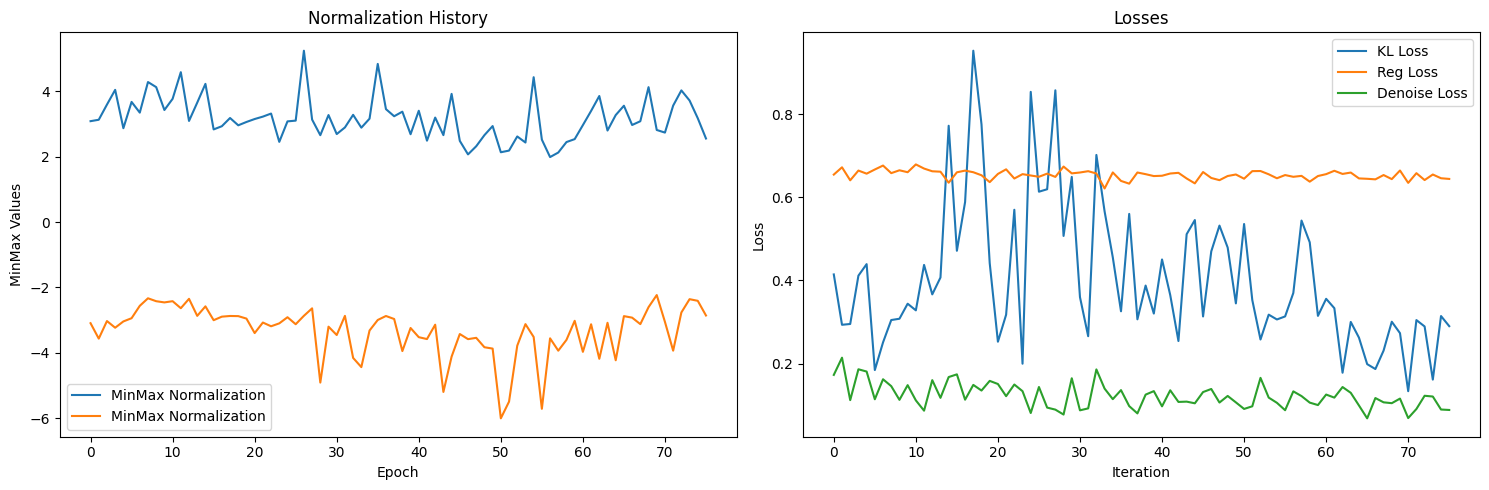

Epoch 1:   5%|▌         | 4/76 [00:08<02:21,  1.96s/it]

step: 80 losses: 0.371450275182724 0.6322329640388489 0.1283142864704132


Epoch 1:  18%|█▊        | 14/76 [00:32<02:00,  1.94s/it]

step: 90 losses: 0.29304441809654236 0.6513882279396057 0.11584337800741196


Epoch 1:  32%|███▏      | 24/76 [00:58<01:42,  1.98s/it]

step: 100 losses: 0.142097607254982 0.6600357294082642 0.08796031773090363


Epoch 1:  45%|████▍     | 34/76 [01:28<01:24,  2.02s/it]

step: 110 losses: 0.31708404421806335 0.6478814482688904 0.08885486423969269


Epoch 1:  58%|█████▊    | 44/76 [01:52<01:01,  1.94s/it]

step: 120 losses: 0.2664108872413635 0.6521521806716919 0.05442855879664421


Epoch 1:  71%|███████   | 54/76 [02:15<00:42,  1.91s/it]

step: 130 losses: 0.23998437821865082 0.6298509836196899 0.13540396094322205


Epoch 1:  84%|████████▍ | 64/76 [02:41<00:23,  1.95s/it]

step: 140 losses: 0.23682694137096405 0.6260133981704712 0.10846878588199615


Epoch 1:  97%|█████████▋| 74/76 [03:04<00:03,  1.95s/it]

step: 150 losses: 0.13955257833003998 0.6464349627494812 0.08319440484046936


Epoch 1: 100%|██████████| 76/76 [03:11<00:00,  2.52s/it]


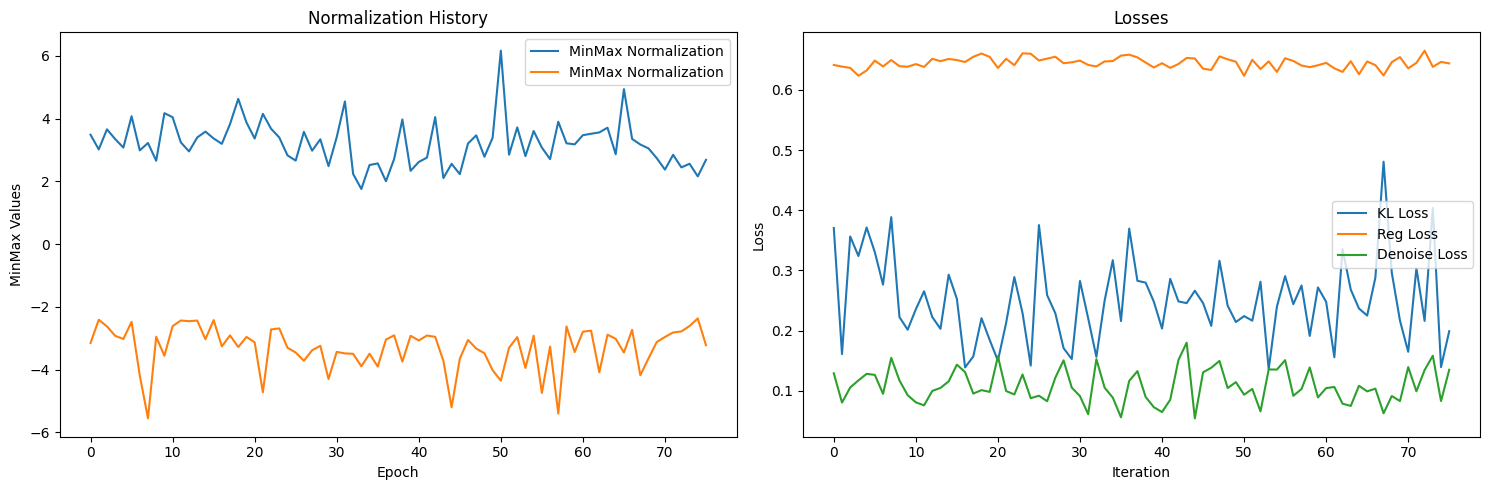

Epoch 2:  11%|█         | 8/76 [00:15<02:08,  1.88s/it]

step: 160 losses: 0.4205166697502136 0.632445216178894 0.09152422845363617


Epoch 2:  24%|██▎       | 18/76 [00:38<01:50,  1.90s/it]

step: 170 losses: 0.33079811930656433 0.6376245021820068 0.1411188691854477


Epoch 2:  37%|███▋      | 28/76 [01:01<01:33,  1.95s/it]

step: 180 losses: 0.27736470103263855 0.6419693231582642 0.06719153374433517


Epoch 2:  50%|█████     | 38/76 [01:29<01:15,  1.99s/it]

step: 190 losses: 0.11812274158000946 0.6518068313598633 0.10426664352416992


Epoch 2:  63%|██████▎   | 48/76 [01:52<00:54,  1.94s/it]

step: 200 losses: 0.18231409788131714 0.6851472854614258 0.1472940444946289


Epoch 2:  76%|███████▋  | 58/76 [02:14<00:34,  1.90s/it]

step: 210 losses: 0.12358124554157257 0.6621171832084656 0.09468161314725876


Epoch 2:  89%|████████▉ | 68/76 [02:40<00:15,  1.96s/it]

step: 220 losses: 0.45014891028404236 0.6574862003326416 0.08653990924358368


Epoch 2: 100%|██████████| 76/76 [02:59<00:00,  2.36s/it]


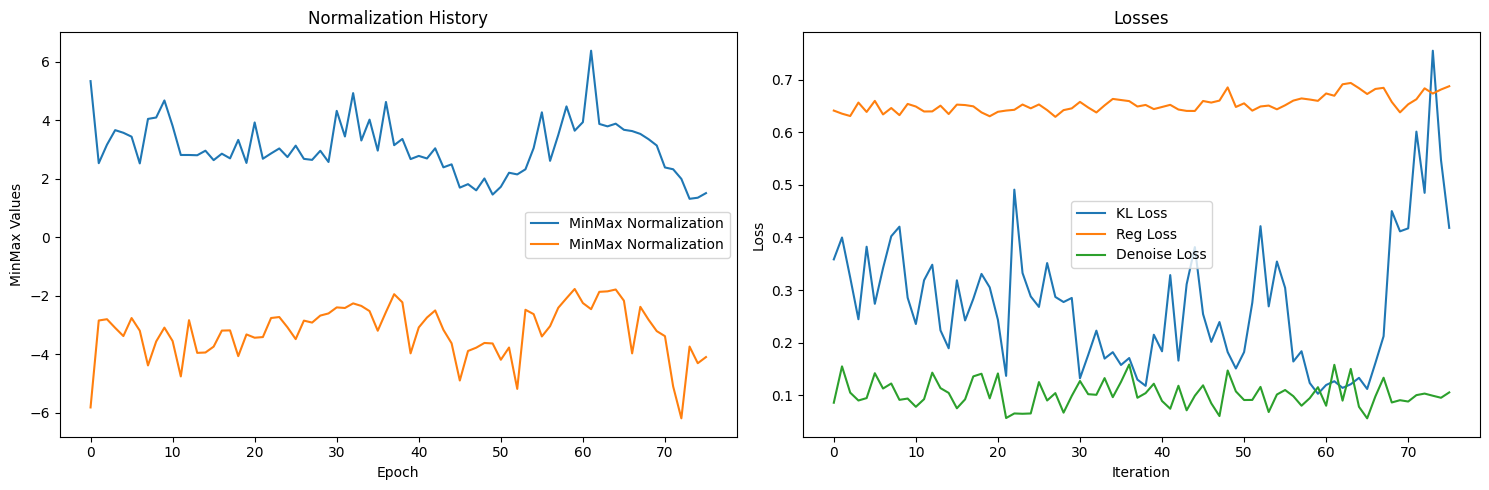

Epoch 3:   3%|▎         | 2/76 [00:04<02:33,  2.08s/it]

step: 230 losses: 0.32934147119522095 0.691945493221283 0.10652172565460205


Epoch 3:  16%|█▌        | 12/76 [00:32<02:08,  2.00s/it]

step: 240 losses: 0.39089149236679077 0.6280233263969421 0.1265656054019928


Epoch 3:  29%|██▉       | 22/76 [00:55<01:44,  1.93s/it]

step: 250 losses: 0.33546528220176697 0.64984130859375 0.10147155821323395


Epoch 3:  42%|████▏     | 32/76 [01:18<01:24,  1.92s/it]

step: 260 losses: 0.21889446675777435 0.6513068675994873 0.1122710108757019


Epoch 3:  55%|█████▌    | 42/76 [01:41<01:04,  1.91s/it]

step: 270 losses: 0.3084421753883362 0.6431148648262024 0.09584357589483261


Epoch 3:  68%|██████▊   | 52/76 [02:03<00:45,  1.92s/it]

step: 280 losses: 0.17158722877502441 0.6304870843887329 0.09444241225719452


Epoch 3:  82%|████████▏ | 62/76 [02:33<00:28,  2.01s/it]

step: 290 losses: 0.33392810821533203 0.6228604316711426 0.0672076940536499


Epoch 3:  95%|█████████▍| 72/76 [02:56<00:07,  1.95s/it]

step: 300 losses: 0.15755075216293335 0.6297237873077393 0.11435860395431519


Epoch 3: 100%|██████████| 76/76 [03:10<00:00,  2.51s/it]


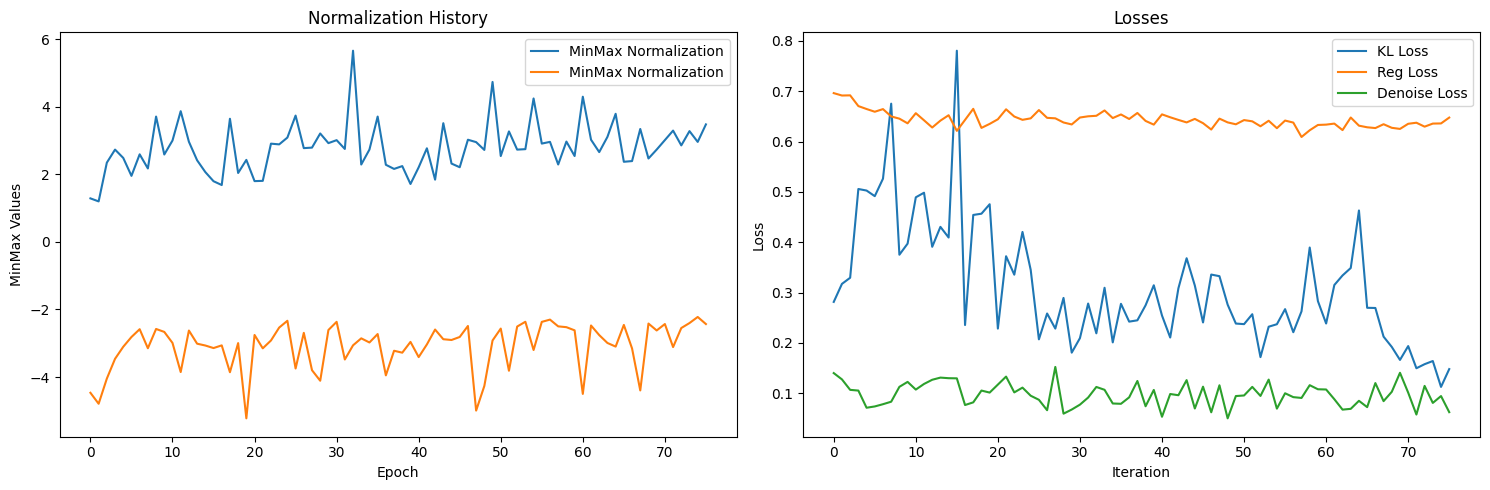

Epoch 4:   8%|▊         | 6/76 [00:11<02:11,  1.88s/it]

step: 310 losses: 0.13838668167591095 0.6463125944137573 0.10120128095149994


Epoch 4:  21%|██        | 16/76 [00:37<01:57,  1.96s/it]

step: 320 losses: 0.21052050590515137 0.636398196220398 0.12437500804662704


Epoch 4:  34%|███▍      | 26/76 [01:01<01:37,  1.94s/it]

step: 330 losses: 0.16398175060749054 0.6431760787963867 0.1172507032752037


Epoch 4:  47%|████▋     | 36/76 [01:28<01:18,  1.97s/it]

step: 340 losses: 0.2042723298072815 0.6393767595291138 0.12900090217590332


Epoch 4:  61%|██████    | 46/76 [01:57<01:00,  2.01s/it]

step: 350 losses: 0.19227539002895355 0.6384575963020325 0.08986061811447144


Epoch 4:  74%|███████▎  | 56/76 [02:24<00:39,  1.98s/it]

step: 360 losses: 0.1224147230386734 0.6401010155677795 0.15695436298847198


Epoch 4:  87%|████████▋ | 66/76 [02:47<00:19,  1.93s/it]

step: 370 losses: 0.20499107241630554 0.6385804414749146 0.10051872581243515


Epoch 4: 100%|██████████| 76/76 [03:11<00:00,  2.52s/it]


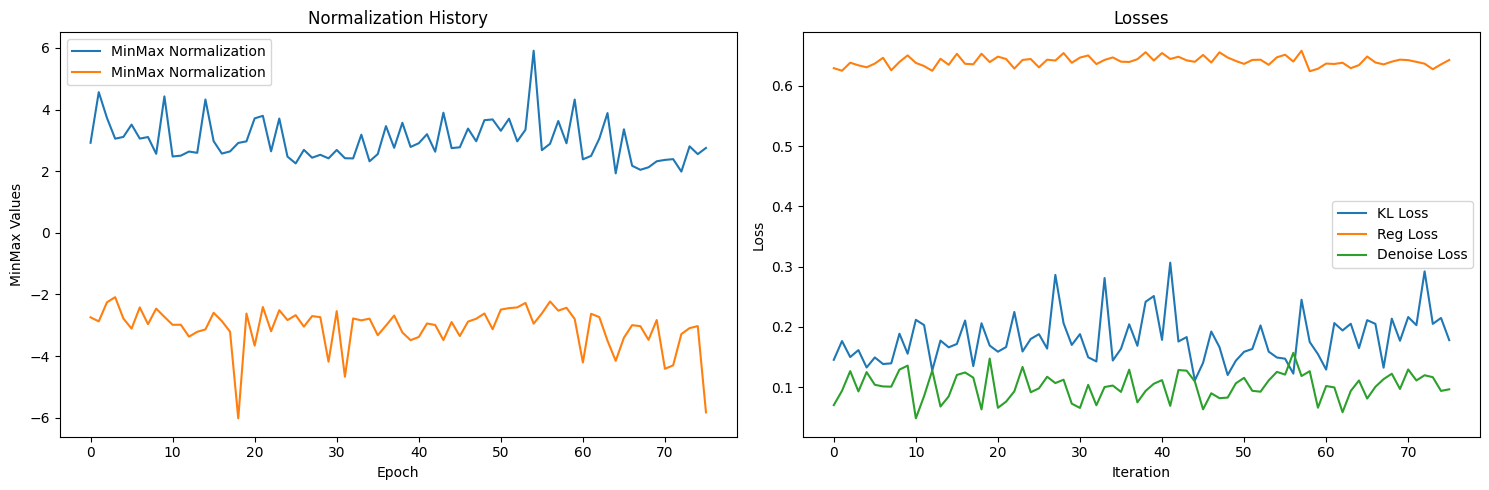

Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

step: 380 losses: 0.22262470424175262 0.6531943082809448 0.08565439283847809


Epoch 5:  13%|█▎        | 10/76 [00:24<02:09,  1.95s/it]

step: 390 losses: 0.10896747559309006 0.6329375505447388 0.0929628238081932


Epoch 5:  26%|██▋       | 20/76 [00:51<01:51,  1.99s/it]

step: 400 losses: 0.2026660442352295 0.6522485017776489 0.08878259360790253


Epoch 5:  39%|███▉      | 30/76 [01:15<01:29,  1.94s/it]

step: 410 losses: 0.12029163539409637 0.6371158361434937 0.11621197313070297


Epoch 5:  53%|█████▎    | 40/76 [01:38<01:08,  1.92s/it]

step: 420 losses: 0.10649971663951874 0.6536418795585632 0.1248956248164177


Epoch 5:  66%|██████▌   | 50/76 [02:07<00:51,  1.99s/it]

step: 430 losses: 0.18118934333324432 0.6357302665710449 0.11623279750347137


Epoch 5:  79%|███████▉  | 60/76 [02:32<00:31,  1.97s/it]

step: 440 losses: 0.15875175595283508 0.6472803354263306 0.11897976696491241


Epoch 5:  92%|█████████▏| 70/76 [02:54<00:11,  1.91s/it]

step: 450 losses: 0.12714576721191406 0.6472305059432983 0.09286731481552124


Epoch 5: 100%|██████████| 76/76 [03:09<00:00,  2.49s/it]


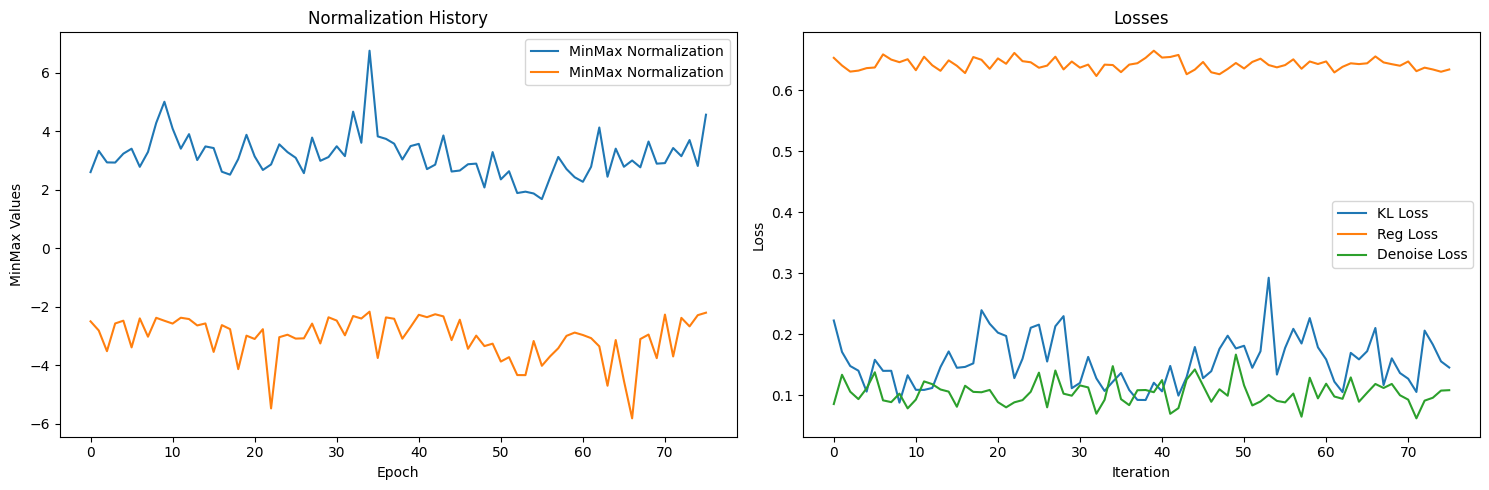

Epoch 6:   5%|▌         | 4/76 [00:07<02:19,  1.93s/it]

step: 460 losses: 0.29313862323760986 0.6351199746131897 0.07400780916213989


Epoch 6:  18%|█▊        | 14/76 [00:36<02:04,  2.01s/it]

step: 470 losses: 0.2693130671977997 0.6480766534805298 0.08239082992076874


Epoch 6:  32%|███▏      | 24/76 [01:00<01:41,  1.95s/it]

step: 480 losses: 0.08975385874509811 0.6482139825820923 0.1738942563533783


Epoch 6:  45%|████▍     | 34/76 [01:26<01:21,  1.95s/it]

step: 490 losses: 0.1486237347126007 0.6493524312973022 0.11023329198360443


Epoch 6:  58%|█████▊    | 44/76 [01:50<01:02,  1.94s/it]

step: 500 losses: 0.17262773215770721 0.6381826996803284 0.06716953217983246


Epoch 6:  71%|███████   | 54/76 [02:14<00:42,  1.95s/it]

step: 510 losses: 0.12812021374702454 0.6371014714241028 0.08308155834674835


Epoch 6:  84%|████████▍ | 64/76 [02:37<00:22,  1.91s/it]

step: 520 losses: 0.18394199013710022 0.6307823061943054 0.07697604596614838


Epoch 6:  97%|█████████▋| 74/76 [02:59<00:03,  1.91s/it]

step: 530 losses: 0.17082878947257996 0.6293622851371765 0.10305339097976685


Epoch 6: 100%|██████████| 76/76 [03:14<00:00,  2.55s/it]


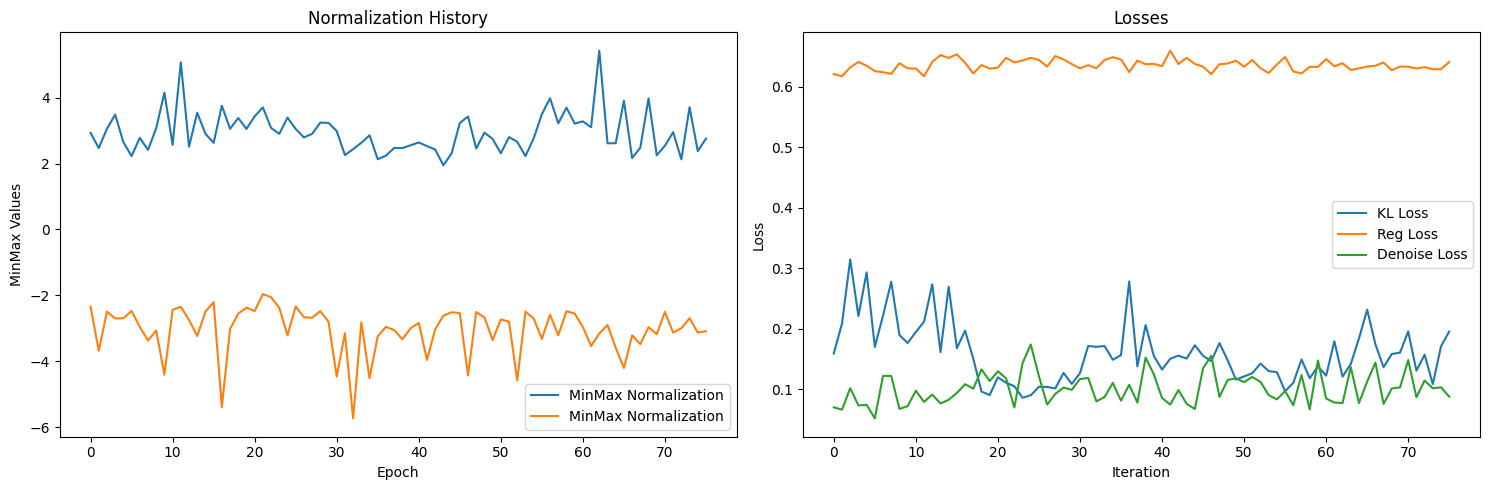

Epoch 7:  11%|█         | 8/76 [00:15<02:09,  1.90s/it]

step: 540 losses: 0.10803501307964325 0.6266564726829529 0.06354139745235443


Epoch 7:  24%|██▎       | 18/76 [00:38<01:53,  1.95s/it]

step: 550 losses: 0.12604083120822906 0.6358731985092163 0.09216178953647614


Epoch 7:  37%|███▋      | 28/76 [01:04<01:33,  1.94s/it]

step: 560 losses: 0.1100466400384903 0.626616358757019 0.06478175520896912


Epoch 7:  50%|█████     | 38/76 [01:29<01:14,  1.95s/it]

step: 570 losses: 0.16003826260566711 0.6261861324310303 0.06198745593428612


Epoch 7:  63%|██████▎   | 48/76 [01:54<00:54,  1.96s/it]

step: 580 losses: 0.11174318194389343 0.6367940306663513 0.08945129811763763


Epoch 7:  76%|███████▋  | 58/76 [02:16<00:34,  1.93s/it]

step: 590 losses: 0.08762596547603607 0.6250558495521545 0.08909666538238525


Epoch 7:  89%|████████▉ | 68/76 [02:39<00:15,  1.91s/it]

step: 600 losses: 0.15263725817203522 0.6433988809585571 0.08786351978778839


Epoch 7: 100%|██████████| 76/76 [03:04<00:00,  2.43s/it]


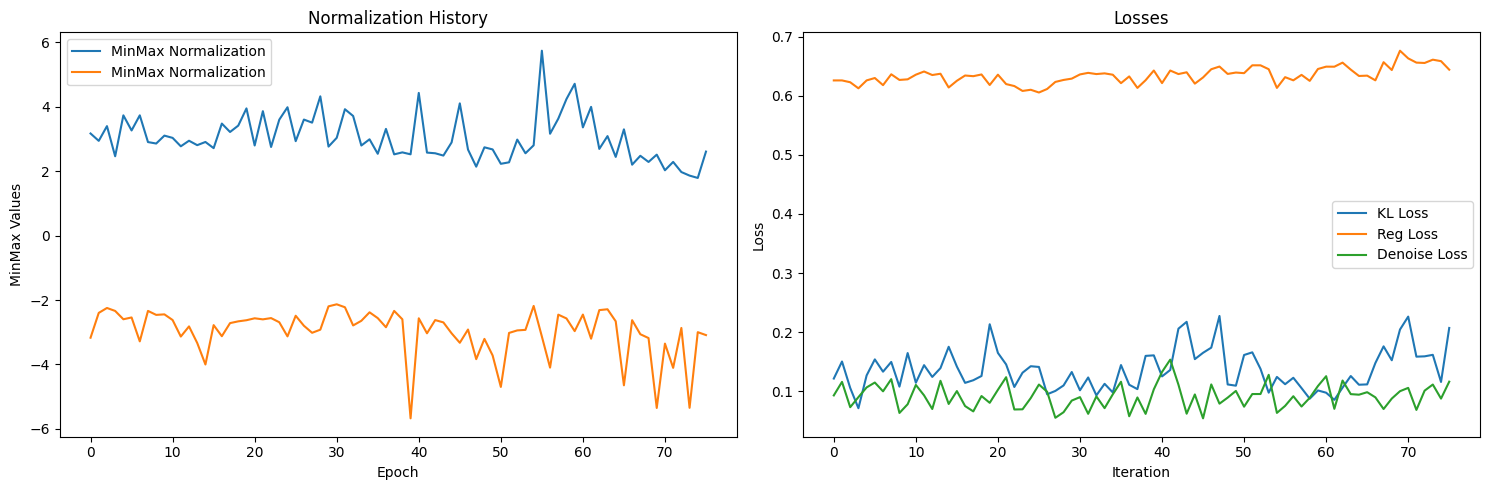

Epoch 8:   3%|▎         | 2/76 [00:04<02:39,  2.16s/it]

step: 610 losses: 0.16375699639320374 0.6356328725814819 0.10264867544174194


Epoch 8:  16%|█▌        | 12/76 [00:27<02:04,  1.95s/it]

step: 620 losses: 0.08217896521091461 0.6430294513702393 0.06560330837965012


Epoch 8:  29%|██▉       | 22/76 [00:49<01:42,  1.90s/it]

step: 630 losses: 0.23499779403209686 0.638573169708252 0.0845441147685051


Epoch 8:  42%|████▏     | 32/76 [01:13<01:24,  1.92s/it]

step: 640 losses: 0.12112516164779663 0.6450163125991821 0.06713312864303589


Epoch 8:  55%|█████▌    | 42/76 [01:40<01:07,  1.99s/it]

step: 650 losses: 0.08937501907348633 0.6450670957565308 0.07907629013061523


Epoch 8:  68%|██████▊   | 52/76 [02:05<00:46,  1.95s/it]

step: 660 losses: 0.20825175940990448 0.6250095367431641 0.07708992063999176


Epoch 8:  82%|████████▏ | 62/76 [02:27<00:26,  1.91s/it]

step: 670 losses: 0.19799703359603882 0.6501190662384033 0.058124542236328125


Epoch 8:  95%|█████████▍| 72/76 [02:50<00:07,  1.91s/it]

step: 680 losses: 0.09511342644691467 0.6429896354675293 0.09527318924665451


Epoch 8: 100%|██████████| 76/76 [03:07<00:00,  2.47s/it]


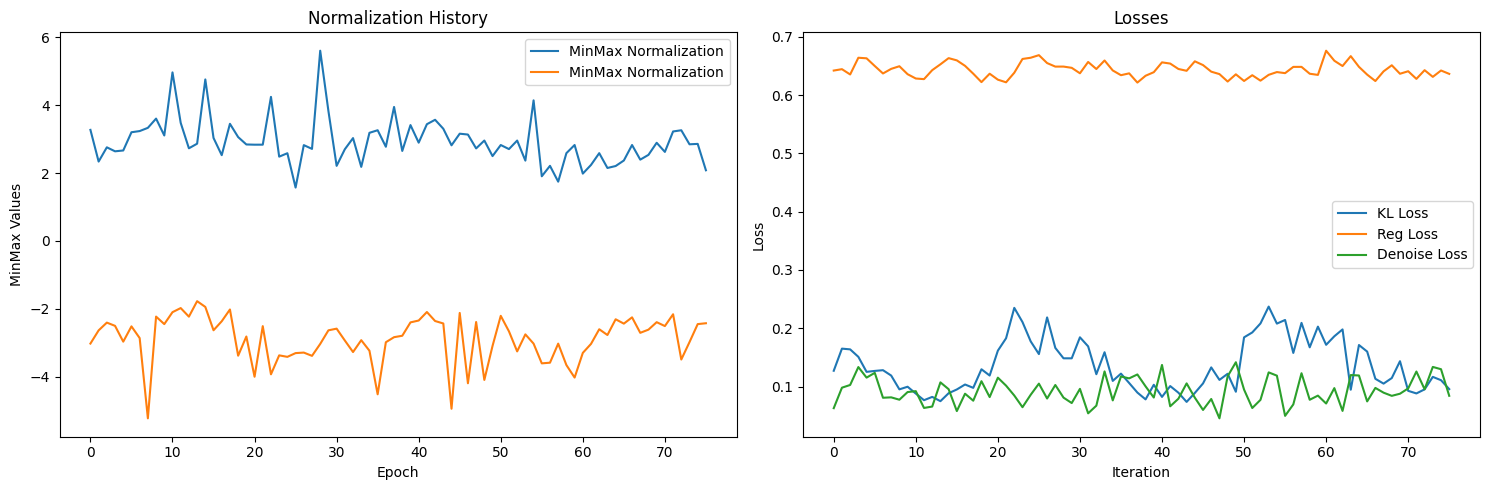

Epoch 9:   5%|▌         | 4/76 [00:18<05:41,  4.74s/it]


KeyboardInterrupt: 

In [ ]:
train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader)

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4158: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


step: 0 losses: 0.0 0.8472155332565308 0.2930562198162079


Epoch 0:  13%|█▎        | 10/76 [00:30<02:00,  1.82s/it]

step: 10 losses: 0.007293651811778545 0.6733306646347046 0.19341114163398743


Epoch 0:  26%|██▋       | 20/76 [00:58<01:40,  1.80s/it]

step: 20 losses: 0.005555341951549053 0.687397837638855 0.19545555114746094


Epoch 0:  39%|███▉      | 30/76 [01:24<01:21,  1.77s/it]

step: 30 losses: 0.02914830669760704 0.6762233972549438 0.23588542640209198


Epoch 0:  53%|█████▎    | 40/76 [01:45<01:02,  1.72s/it]

step: 40 losses: 0.10935264080762863 0.6589697599411011 0.12584617733955383


Epoch 0:  66%|██████▌   | 50/76 [02:05<00:44,  1.72s/it]

step: 50 losses: 0.11816756427288055 0.6645216345787048 0.0888419970870018


Epoch 0:  79%|███████▉  | 60/76 [02:26<00:27,  1.72s/it]

step: 60 losses: 0.4165312647819519 0.6503939628601074 0.1721394956111908


Epoch 0:  92%|█████████▏| 70/76 [02:46<00:10,  1.73s/it]

step: 70 losses: 0.3060725927352905 0.6532321572303772 0.16373276710510254


Epoch 0: 100%|██████████| 76/76 [03:00<00:00,  2.38s/it]


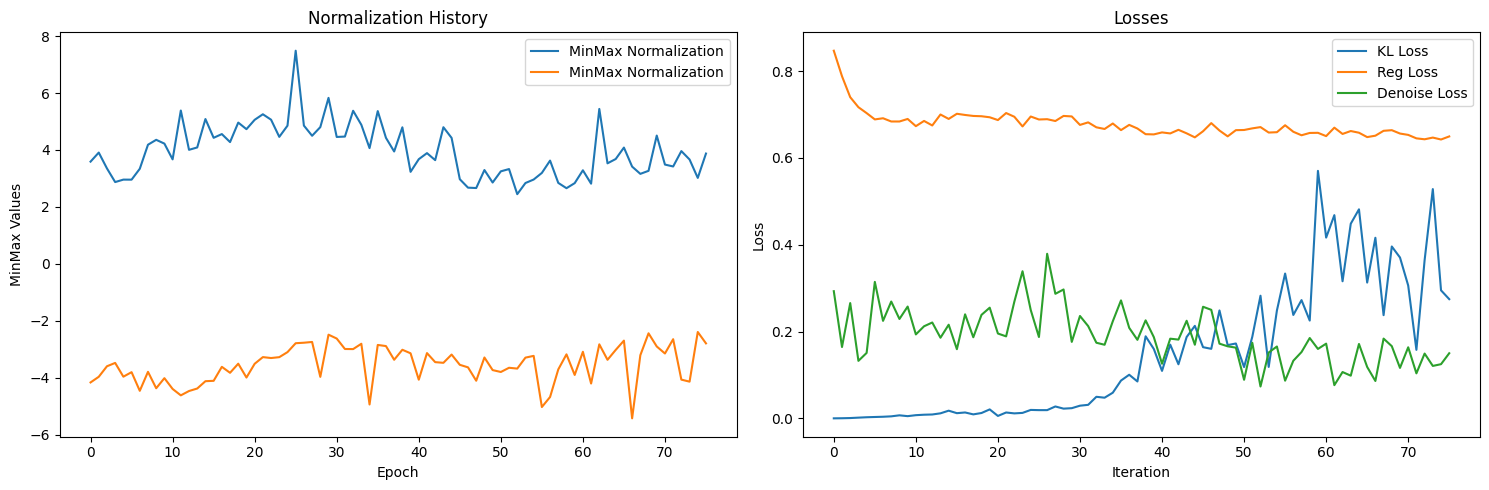

IndexError: index 10 is out of bounds for dimension 0 with size 10

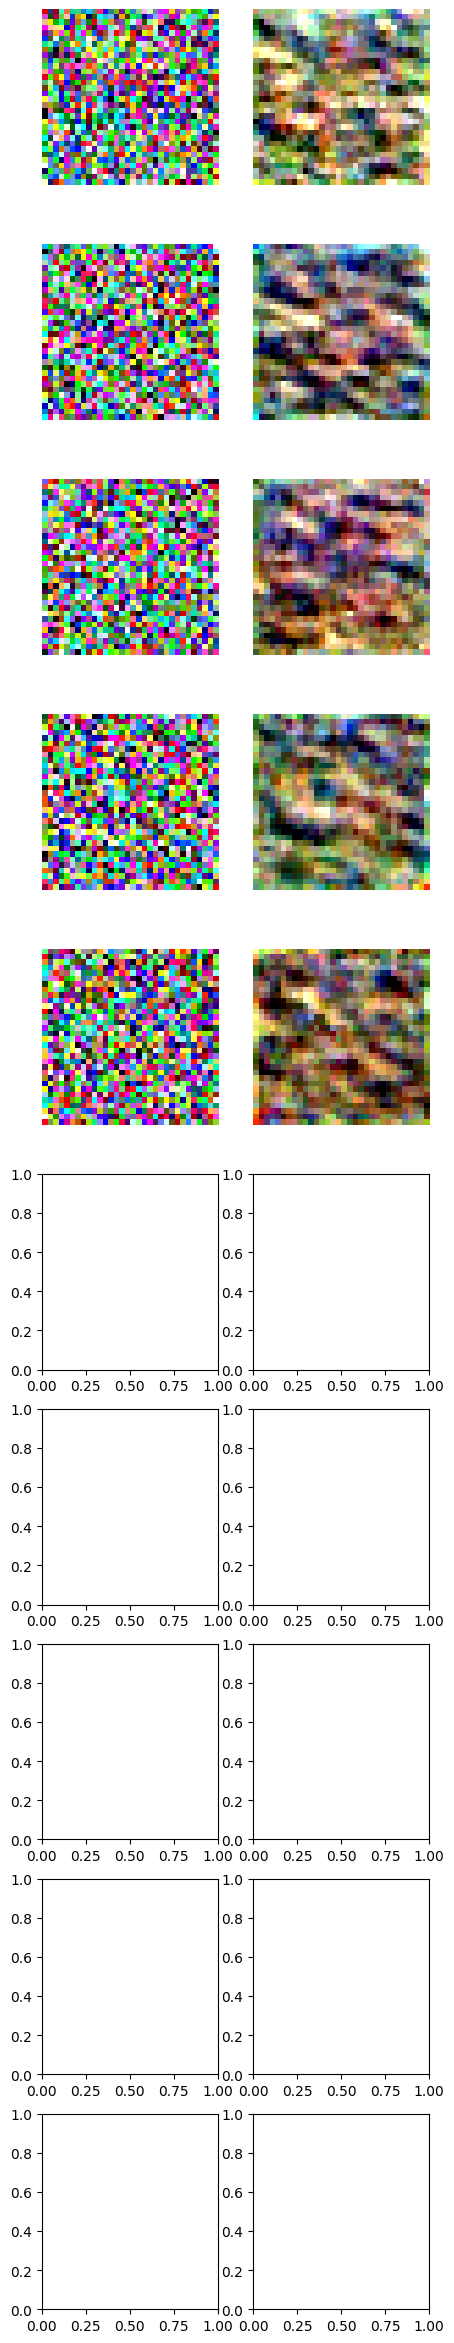

In [38]:
train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader)

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4158: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


step: 0 losses: 0.22454318404197693 0.6346465945243835 0.12485959380865097


Epoch 0:  13%|█▎        | 10/76 [00:25<01:56,  1.77s/it]

step: 10 losses: 0.2624484896659851 0.6446302533149719 0.1270749270915985


Epoch 0:  26%|██▋       | 20/76 [00:45<01:35,  1.71s/it]

step: 20 losses: 0.6193975806236267 0.6526612043380737 0.08510519564151764


Epoch 0:  39%|███▉      | 30/76 [01:10<01:21,  1.78s/it]

step: 30 losses: 0.4743623733520508 0.6487544178962708 0.12247997522354126


Epoch 0:  53%|█████▎    | 40/76 [01:34<01:03,  1.76s/it]

step: 40 losses: 0.2324126809835434 0.6389725804328918 0.0887184739112854


Epoch 0:  66%|██████▌   | 50/76 [01:55<00:44,  1.73s/it]

step: 50 losses: 0.2809031903743744 0.6512354612350464 0.1108594760298729


Epoch 0:  79%|███████▉  | 60/76 [02:15<00:27,  1.73s/it]

step: 60 losses: 0.3203732371330261 0.6572537422180176 0.07450428605079651


Epoch 0:  92%|█████████▏| 70/76 [02:35<00:10,  1.74s/it]

step: 70 losses: 0.42211639881134033 0.6523723006248474 0.09691280126571655


Epoch 0: 100%|██████████| 76/76 [02:49<00:00,  1.91s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 0: 100%|██████████| 76/76 [02:49<00:00,  2.24s/it]


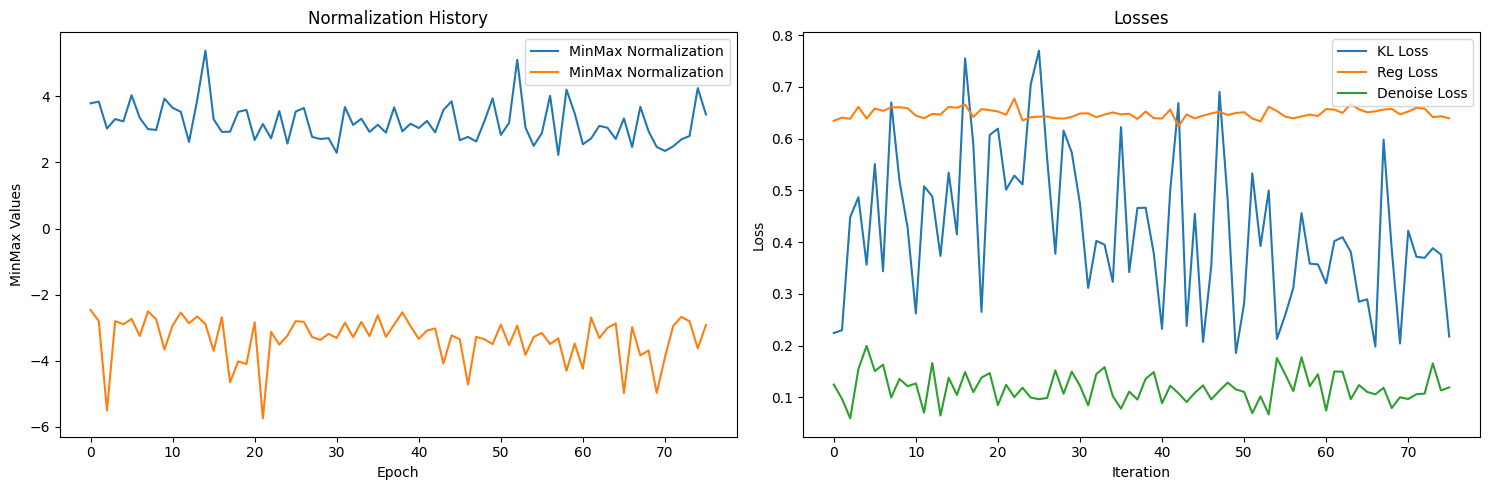

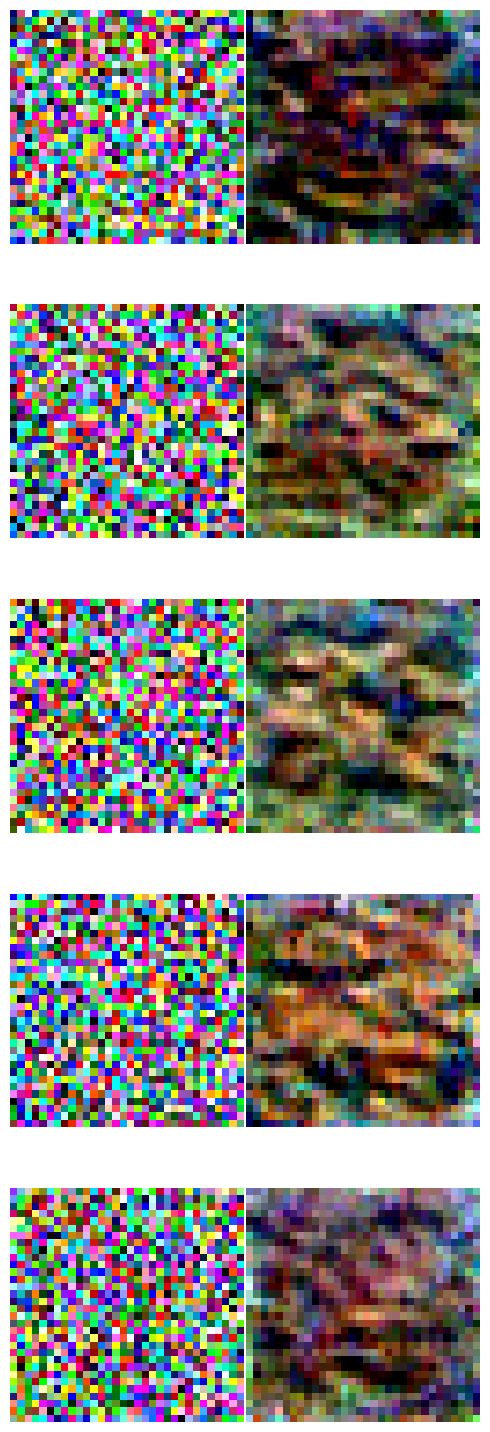

Epoch 1:   5%|▌         | 4/76 [00:07<02:08,  1.79s/it]

step: 80 losses: 0.3294142186641693 0.6317524909973145 0.13758108019828796


Epoch 1:  18%|█▊        | 14/76 [00:29<01:51,  1.79s/it]

step: 90 losses: 0.2661110460758209 0.6448686122894287 0.09181457757949829


Epoch 1:  32%|███▏      | 24/76 [00:51<01:31,  1.76s/it]

step: 100 losses: 0.274484246969223 0.6424378752708435 0.08406295627355576


Epoch 1:  45%|████▍     | 34/76 [01:12<01:13,  1.75s/it]

step: 110 losses: 0.3645654618740082 0.6321797966957092 0.1109776496887207


Epoch 1:  58%|█████▊    | 44/76 [01:35<00:57,  1.78s/it]

step: 120 losses: 0.21285775303840637 0.6292900443077087 0.08334845304489136


Epoch 1:  71%|███████   | 54/76 [01:56<00:38,  1.76s/it]

step: 130 losses: 0.284479558467865 0.6372638940811157 0.13615036010742188


Epoch 1:  84%|████████▍ | 64/76 [02:17<00:21,  1.76s/it]

step: 140 losses: 0.20248518884181976 0.6511794328689575 0.09911412000656128


Epoch 1:  97%|█████████▋| 74/76 [02:40<00:03,  1.78s/it]

step: 150 losses: 0.22283470630645752 0.6435415148735046 0.10451452434062958


Epoch 1: 100%|██████████| 76/76 [02:47<00:00,  2.21s/it]


<Figure size 640x480 with 0 Axes>

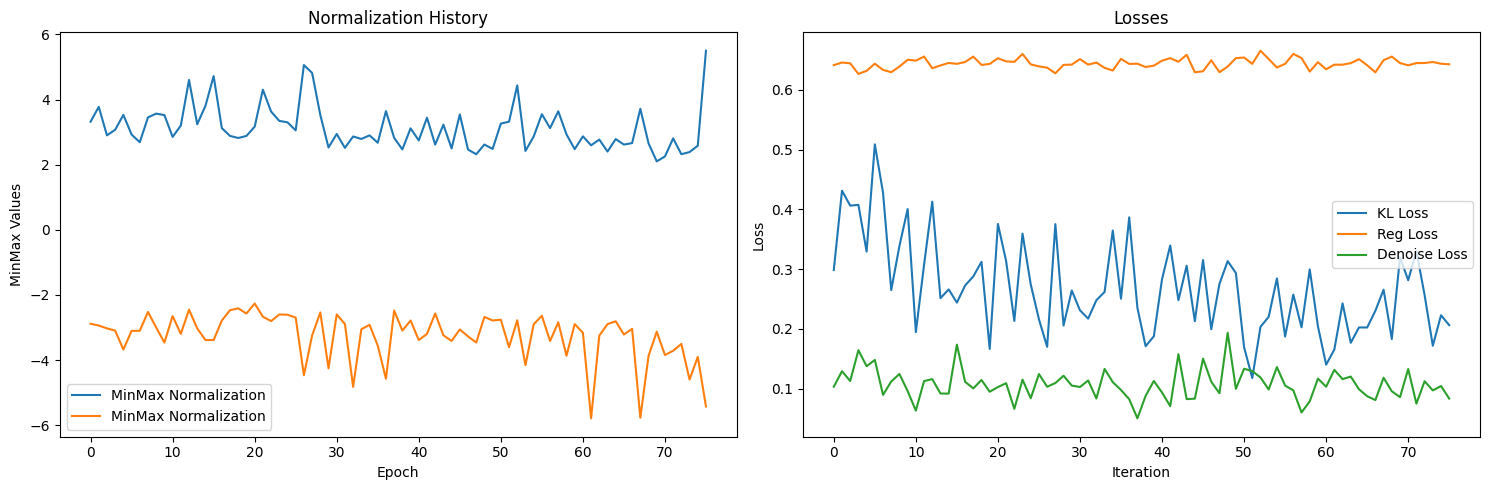

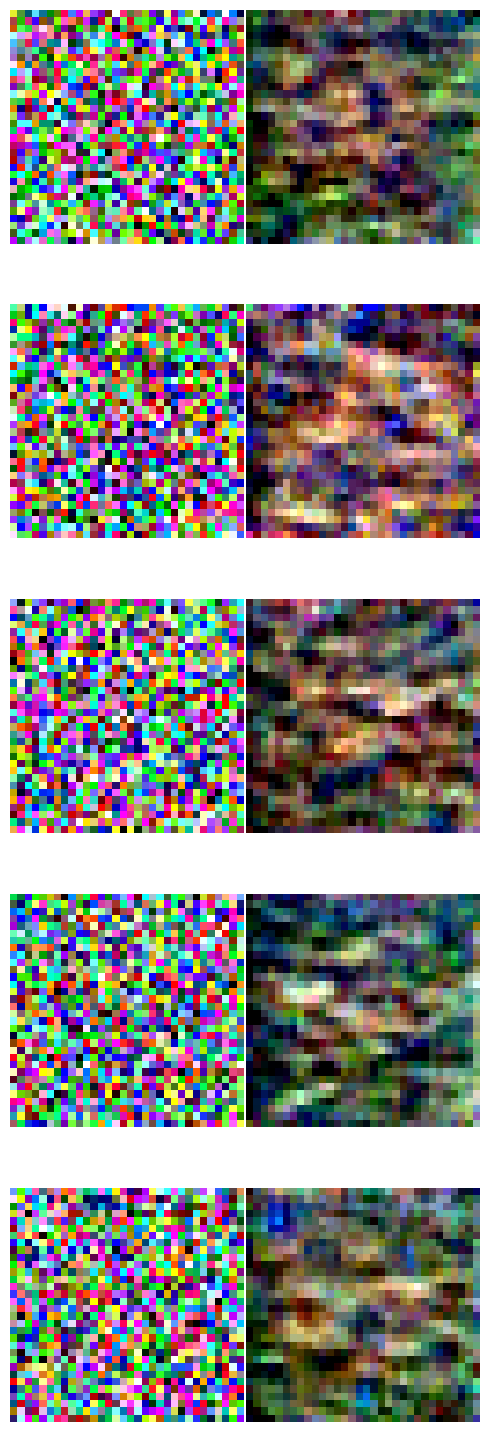

Epoch 2:  11%|█         | 8/76 [00:14<01:56,  1.72s/it]

step: 160 losses: 0.18613135814666748 0.6554040312767029 0.1269562840461731


Epoch 2:  24%|██▎       | 18/76 [00:34<01:41,  1.75s/it]

step: 170 losses: 0.16590800881385803 0.6560095548629761 0.14209917187690735


Epoch 2:  37%|███▋      | 28/76 [00:57<01:25,  1.77s/it]

step: 180 losses: 0.24295344948768616 0.633409857749939 0.06971035897731781


Epoch 2:  50%|█████     | 38/76 [01:22<01:08,  1.81s/it]

step: 190 losses: 0.366710364818573 0.6586072444915771 0.08337591588497162


Epoch 2:  63%|██████▎   | 48/76 [01:43<00:49,  1.76s/it]

step: 200 losses: 0.11473637819290161 0.6722744703292847 0.09414732456207275


Epoch 2:  76%|███████▋  | 58/76 [02:10<00:32,  1.83s/it]

step: 210 losses: 0.32404062151908875 0.6342656016349792 0.10917910188436508


Epoch 2:  89%|████████▉ | 68/76 [02:31<00:14,  1.77s/it]

step: 220 losses: 0.28372108936309814 0.657048225402832 0.0726156234741211


Epoch 2: 100%|██████████| 76/76 [02:49<00:00,  2.23s/it]


<Figure size 640x480 with 0 Axes>

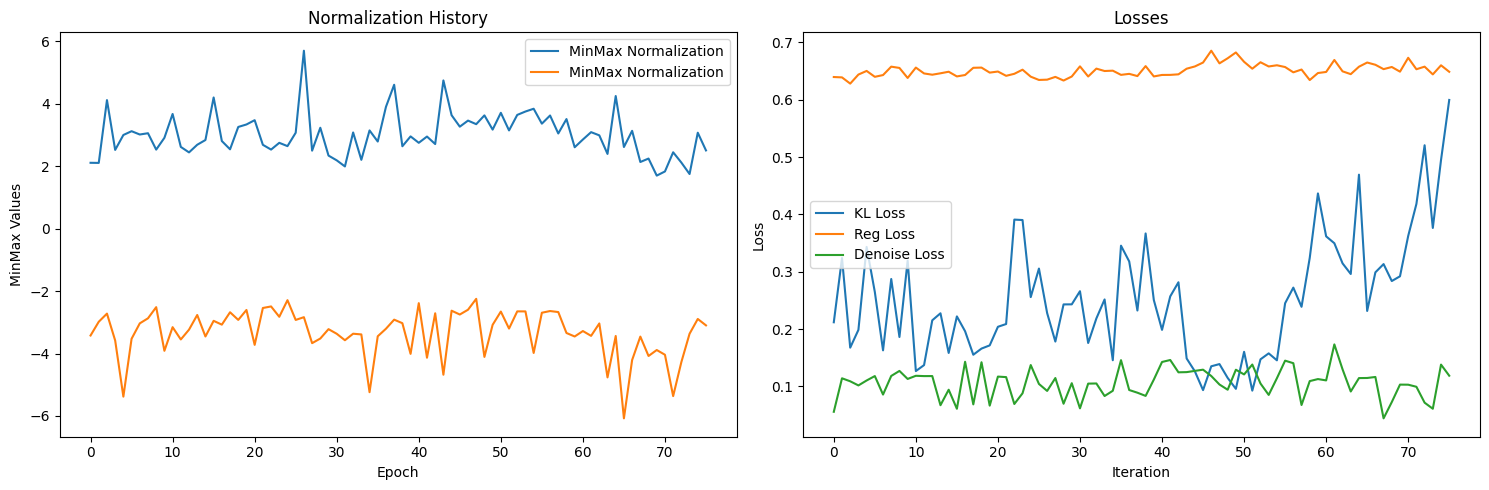

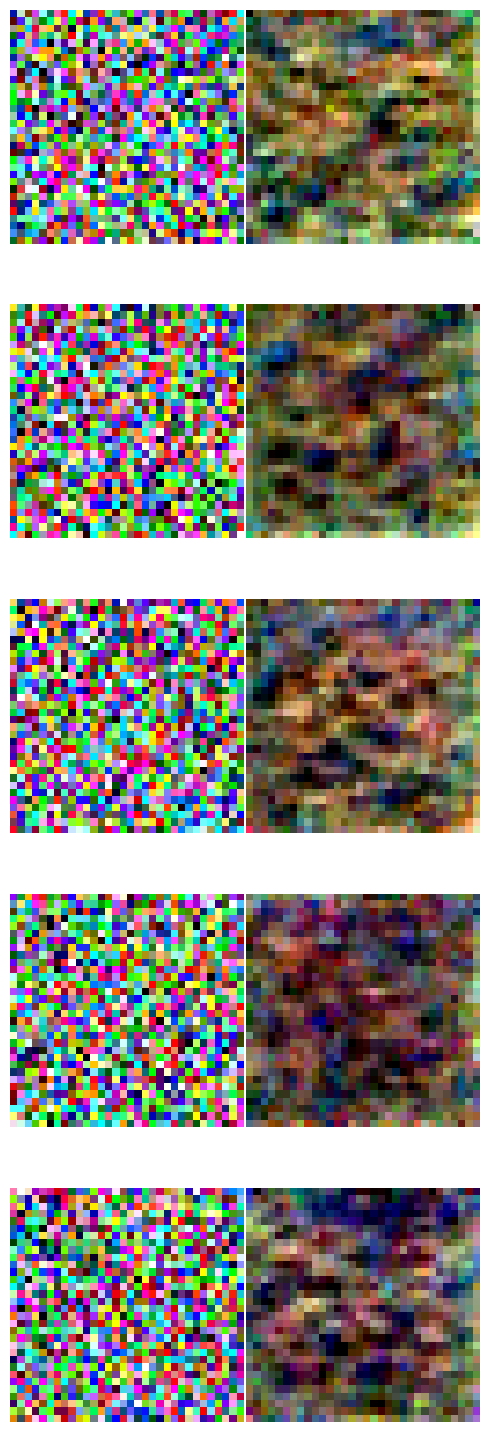

Epoch 3:   3%|▎         | 2/76 [00:04<02:31,  2.05s/it]

step: 230 losses: 0.3561028838157654 0.6408434510231018 0.1047423705458641


Epoch 3:  16%|█▌        | 12/76 [00:24<01:53,  1.77s/it]

step: 240 losses: 0.3294539153575897 0.6431365013122559 0.0886075347661972


Epoch 3:  29%|██▉       | 22/76 [00:46<01:36,  1.80s/it]

step: 250 losses: 0.4187241792678833 0.635152280330658 0.09323736280202866


Epoch 3:  42%|████▏     | 32/76 [01:07<01:18,  1.79s/it]

step: 260 losses: 0.391304612159729 0.6299443244934082 0.05896691232919693


Epoch 3:  55%|█████▌    | 42/76 [01:28<01:00,  1.78s/it]

step: 270 losses: 0.2739102244377136 0.6476768851280212 0.08800678700208664


Epoch 3:  68%|██████▊   | 52/76 [01:49<00:42,  1.78s/it]

step: 280 losses: 0.33447131514549255 0.6467579007148743 0.09047858417034149


Epoch 3:  82%|████████▏ | 62/76 [02:11<00:25,  1.80s/it]

step: 290 losses: 0.3661069869995117 0.6406830549240112 0.07066340744495392


Epoch 3:  95%|█████████▍| 72/76 [02:33<00:07,  1.80s/it]

step: 300 losses: 0.286754846572876 0.6421176195144653 0.09408627450466156


Epoch 3: 100%|██████████| 76/76 [02:43<00:00,  2.16s/it]


<Figure size 640x480 with 0 Axes>

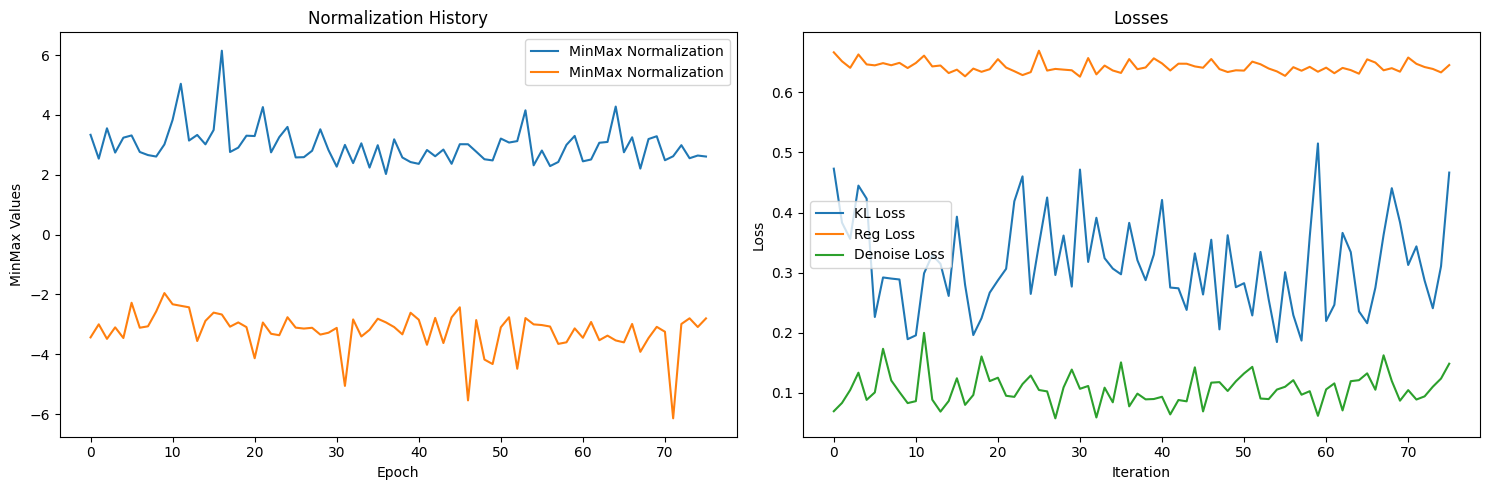

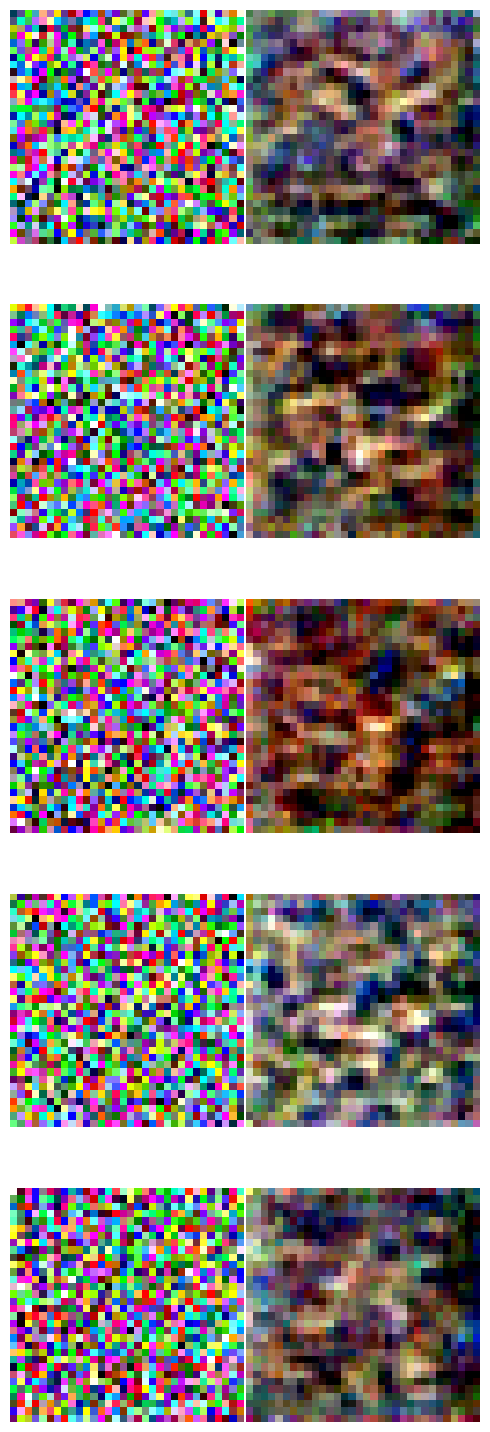

Epoch 4:   8%|▊         | 6/76 [00:11<02:04,  1.78s/it]

step: 310 losses: 0.3242466151714325 0.6267929077148438 0.10226421803236008


Epoch 4:  21%|██        | 16/76 [00:34<01:49,  1.82s/it]

step: 320 losses: 0.24718335270881653 0.6378371715545654 0.0748794823884964


Epoch 4:  34%|███▍      | 26/76 [00:56<01:29,  1.79s/it]

step: 330 losses: 0.20807597041130066 0.6662173271179199 0.1119602844119072


Epoch 4:  47%|████▋     | 36/76 [01:17<01:11,  1.78s/it]

step: 340 losses: 0.16457055509090424 0.6619176864624023 0.1154060810804367


Epoch 4:  61%|██████    | 46/76 [01:37<00:53,  1.77s/it]

step: 350 losses: 0.21347753703594208 0.6462284326553345 0.0915357694029808


Epoch 4:  74%|███████▎  | 56/76 [02:01<00:35,  1.80s/it]

step: 360 losses: 0.11964750289916992 0.6496255397796631 0.11119510978460312


Epoch 4:  87%|████████▋ | 66/76 [02:21<00:17,  1.76s/it]

step: 370 losses: 0.2534523904323578 0.6168784499168396 0.09152810275554657


Epoch 4: 100%|██████████| 76/76 [02:42<00:00,  2.14s/it]


<Figure size 640x480 with 0 Axes>

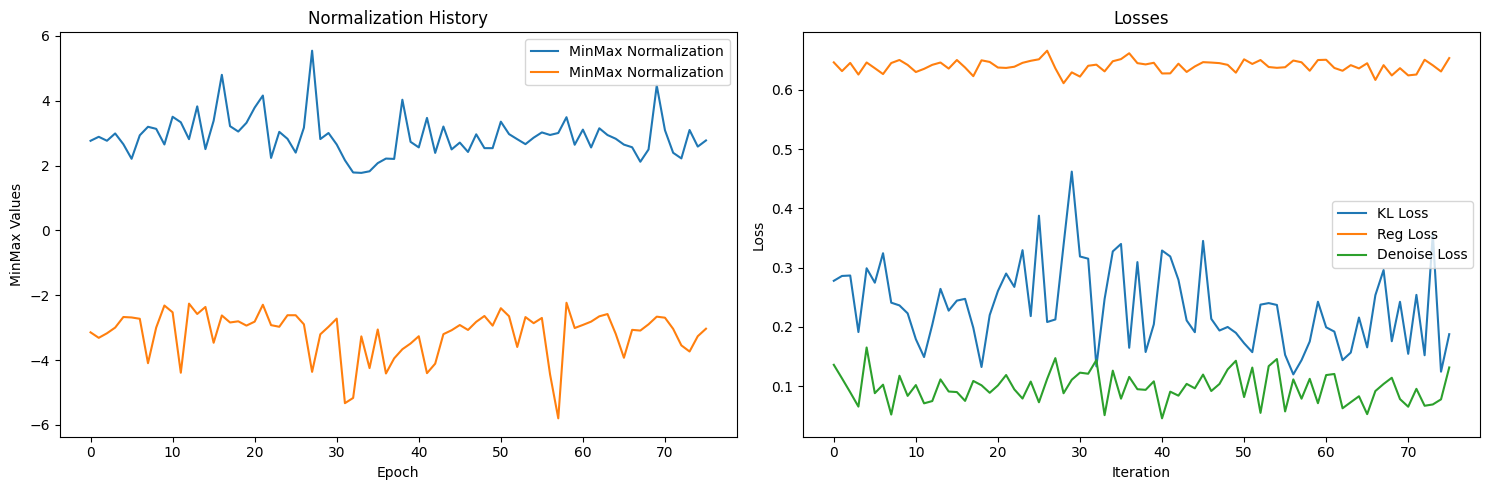

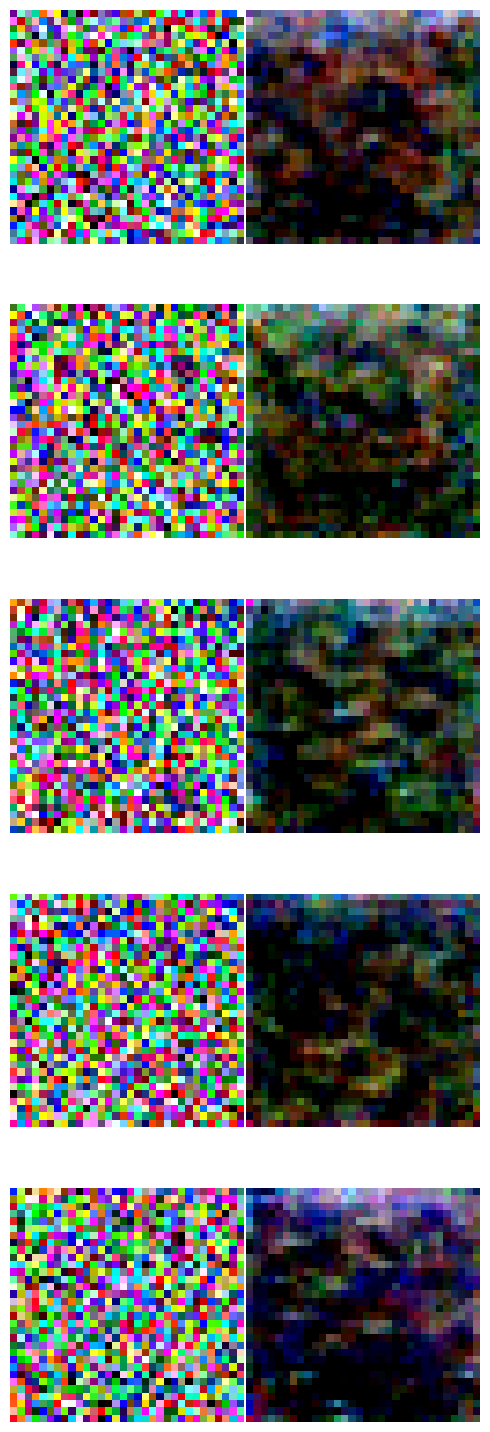

Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

step: 380 losses: 0.210453063249588 0.635864794254303 0.09538666903972626


Epoch 5:  13%|█▎        | 10/76 [00:22<01:57,  1.78s/it]

step: 390 losses: 0.20820823311805725 0.6389516592025757 0.08921965211629868


Epoch 5:  26%|██▋       | 20/76 [00:48<01:42,  1.82s/it]

step: 400 losses: 0.11272072046995163 0.6445233225822449 0.0740957111120224


Epoch 5:  39%|███▉      | 30/76 [01:09<01:20,  1.75s/it]

step: 410 losses: 0.2668682932853699 0.632247269153595 0.14587166905403137


Epoch 5:  53%|█████▎    | 40/76 [01:30<01:03,  1.76s/it]

step: 420 losses: 0.18469922244548798 0.6292059421539307 0.08462950587272644


Epoch 5:  66%|██████▌   | 50/76 [01:54<00:46,  1.80s/it]

step: 430 losses: 0.16716593503952026 0.6353734731674194 0.12336878478527069


Epoch 5:  79%|███████▉  | 60/76 [02:15<00:28,  1.76s/it]

step: 440 losses: 0.25679051876068115 0.6447433233261108 0.11596216261386871


Epoch 5:  92%|█████████▏| 70/76 [02:36<00:10,  1.75s/it]

step: 450 losses: 0.16894535720348358 0.6399098634719849 0.09029339253902435


Epoch 5: 100%|██████████| 76/76 [02:50<00:00,  2.25s/it]


<Figure size 640x480 with 0 Axes>

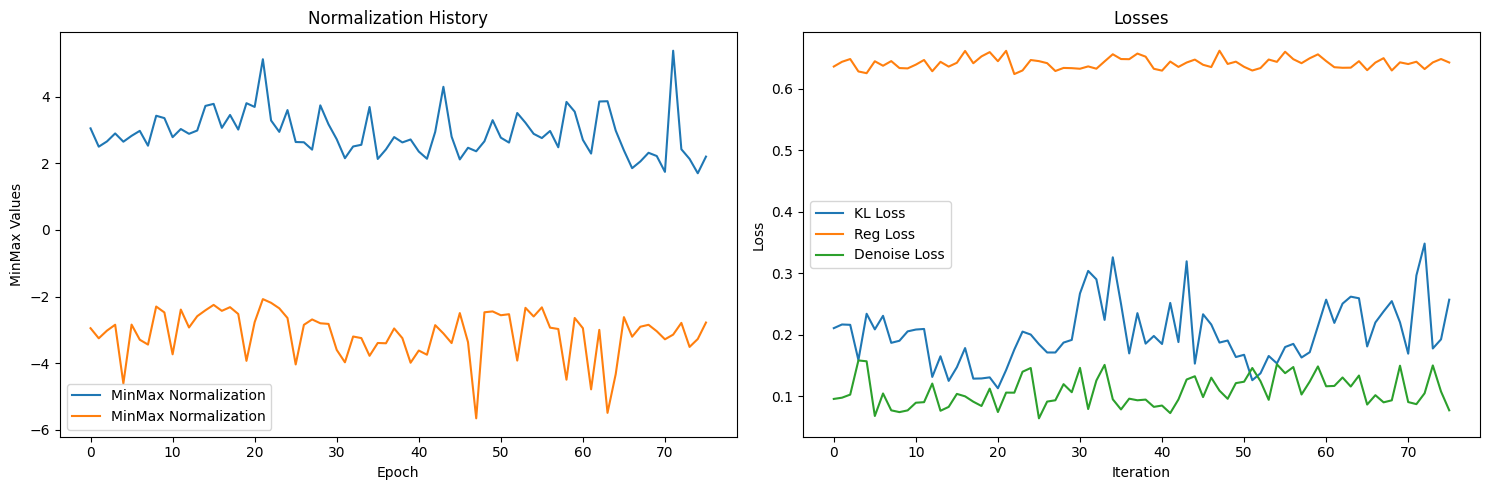

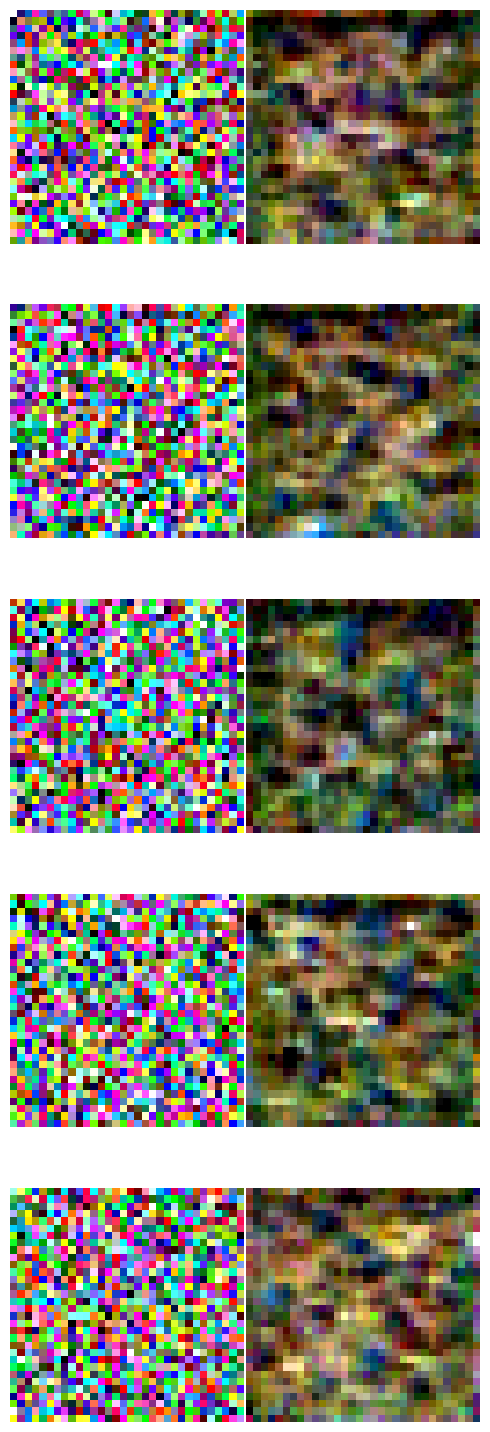

Epoch 6:   5%|▌         | 4/76 [00:07<02:08,  1.78s/it]

step: 460 losses: 0.25197070837020874 0.6461221575737 0.07994324713945389


Epoch 6:  18%|█▊        | 14/76 [00:28<01:49,  1.76s/it]

step: 470 losses: 0.21400086581707 0.6460769772529602 0.07589485496282578


Epoch 6:  32%|███▏      | 24/76 [00:51<01:32,  1.78s/it]

step: 480 losses: 0.13660693168640137 0.6516529321670532 0.10863131284713745


Epoch 6:  45%|████▍     | 34/76 [01:11<01:13,  1.76s/it]

step: 490 losses: 0.2227245420217514 0.6362440586090088 0.13481588661670685


Epoch 6:  58%|█████▊    | 44/76 [01:32<00:56,  1.75s/it]

step: 500 losses: 0.20590826869010925 0.6499553918838501 0.08067210018634796


Epoch 6:  71%|███████   | 54/76 [01:56<00:39,  1.79s/it]

step: 510 losses: 0.19813063740730286 0.6401549577713013 0.08079548925161362


Epoch 6:  84%|████████▍ | 64/76 [02:20<00:21,  1.80s/it]

step: 520 losses: 0.17560641467571259 0.6413275003433228 0.07835354655981064


Epoch 6:  97%|█████████▋| 74/76 [02:41<00:03,  1.75s/it]

step: 530 losses: 0.14540477097034454 0.6218960285186768 0.1417742669582367


Epoch 6: 100%|██████████| 76/76 [02:49<00:00,  2.22s/it]


<Figure size 640x480 with 0 Axes>

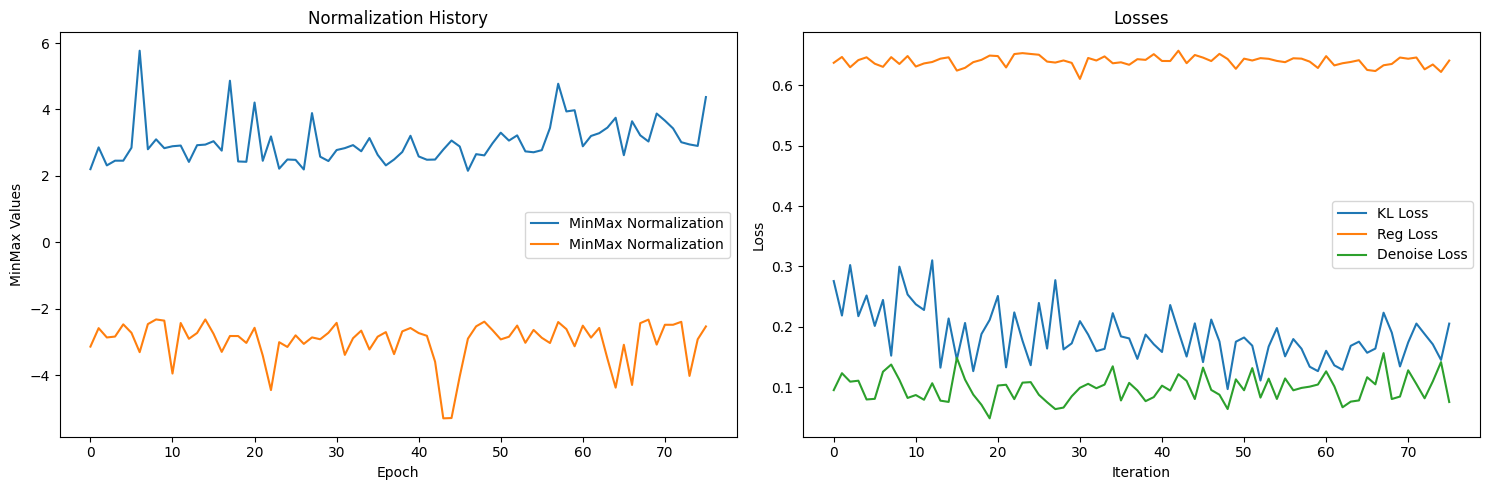

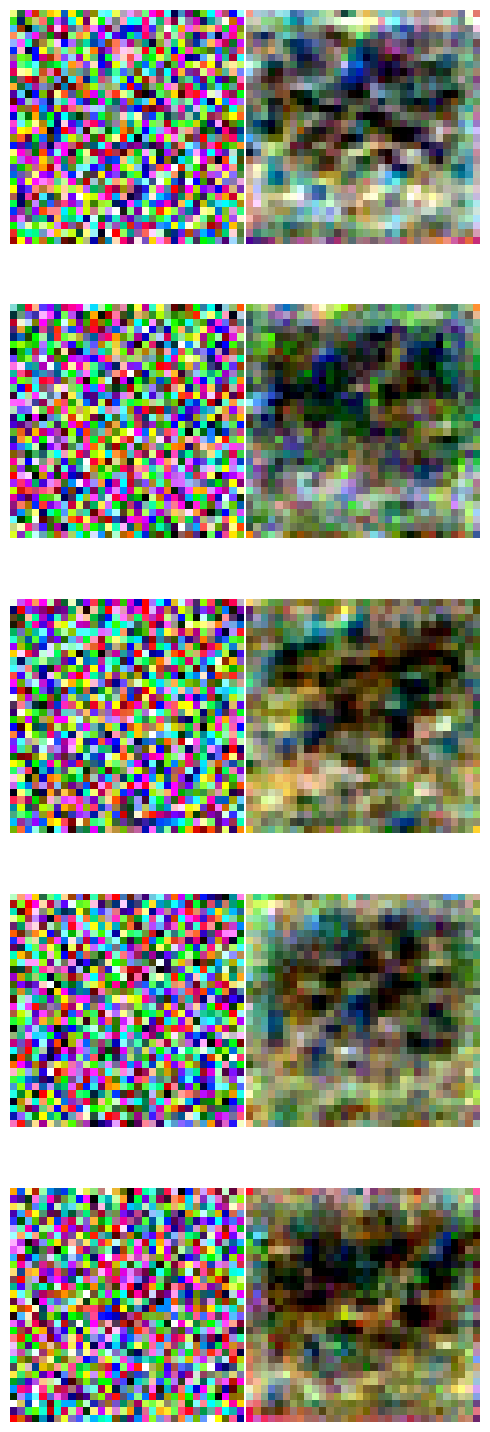

Epoch 7:  11%|█         | 8/76 [00:14<01:56,  1.72s/it]

step: 540 losses: 0.17130452394485474 0.6266170740127563 0.11463624238967896


Epoch 7:  24%|██▎       | 18/76 [00:35<01:42,  1.76s/it]

step: 550 losses: 0.2401965707540512 0.6347655057907104 0.10196399688720703


Epoch 7:  37%|███▋      | 28/76 [00:56<01:24,  1.76s/it]

step: 560 losses: 0.144462451338768 0.6379106640815735 0.08411603420972824


Epoch 7:  50%|█████     | 38/76 [01:17<01:06,  1.76s/it]

step: 570 losses: 0.1593979299068451 0.632061243057251 0.15656934678554535


Epoch 7:  63%|██████▎   | 48/76 [01:41<00:50,  1.79s/it]

step: 580 losses: 0.1548113226890564 0.6439892649650574 0.11352533102035522


Epoch 7:  76%|███████▋  | 58/76 [02:03<00:32,  1.78s/it]

step: 590 losses: 0.11443128436803818 0.6279358863830566 0.12356635183095932


Epoch 7:  89%|████████▉ | 68/76 [02:24<00:14,  1.75s/it]

step: 600 losses: 0.17207595705986023 0.6331547498703003 0.13223479688167572


Epoch 7: 100%|██████████| 76/76 [02:41<00:00,  2.12s/it]


<Figure size 640x480 with 0 Axes>

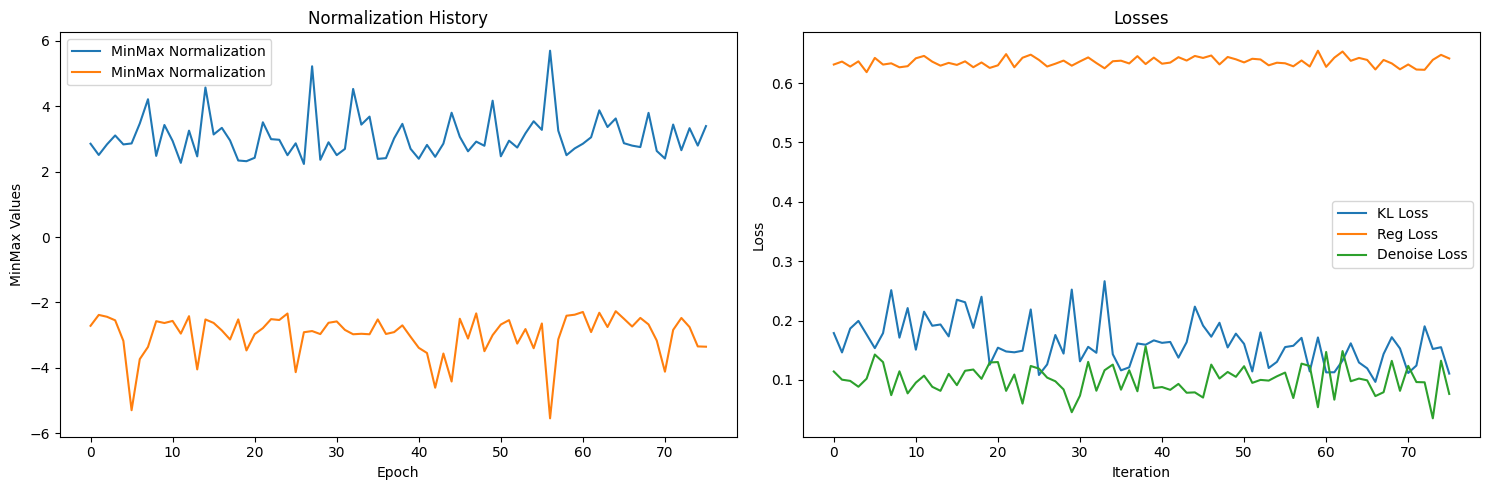

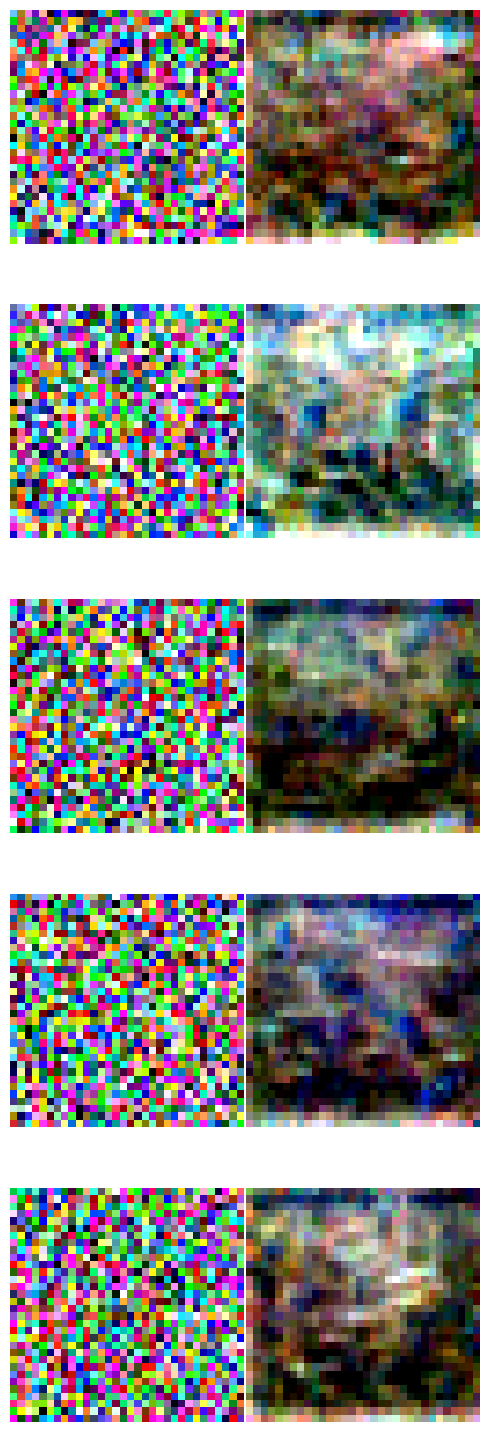

Epoch 8:   3%|▎         | 2/76 [00:04<02:32,  2.07s/it]

step: 610 losses: 0.16982625424861908 0.6262651085853577 0.12035038322210312


Epoch 8:  16%|█▌        | 12/76 [00:24<01:52,  1.76s/it]

step: 620 losses: 0.241276353597641 0.6326828002929688 0.10251741111278534


Epoch 8:  29%|██▉       | 22/76 [00:46<01:35,  1.77s/it]

step: 630 losses: 0.14685331284999847 0.6252662539482117 0.1535908579826355


Epoch 8:  42%|████▏     | 32/76 [01:07<01:17,  1.76s/it]

step: 640 losses: 0.18858985602855682 0.6369410753250122 0.10737405717372894


Epoch 8:  55%|█████▌    | 42/76 [01:28<00:59,  1.75s/it]

step: 650 losses: 0.1512046754360199 0.6355267763137817 0.12956681847572327


Epoch 8:  68%|██████▊   | 52/76 [01:52<00:42,  1.78s/it]

step: 660 losses: 0.14075200259685516 0.6301673650741577 0.09906837344169617


Epoch 8:  82%|████████▏ | 62/76 [02:13<00:24,  1.76s/it]

step: 670 losses: 0.14792200922966003 0.640906572341919 0.09906302392482758


Epoch 8:  95%|█████████▍| 72/76 [02:34<00:07,  1.77s/it]

step: 680 losses: 0.1571652591228485 0.6156754493713379 0.08859632909297943


Epoch 8: 100%|██████████| 76/76 [02:46<00:00,  2.19s/it]


<Figure size 640x480 with 0 Axes>

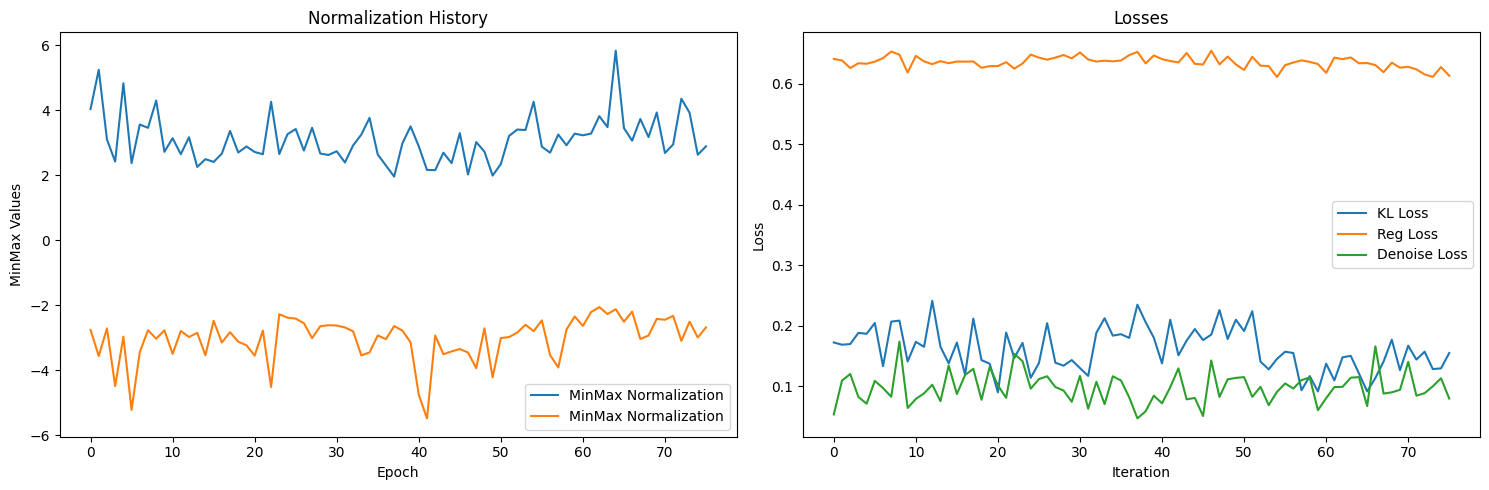

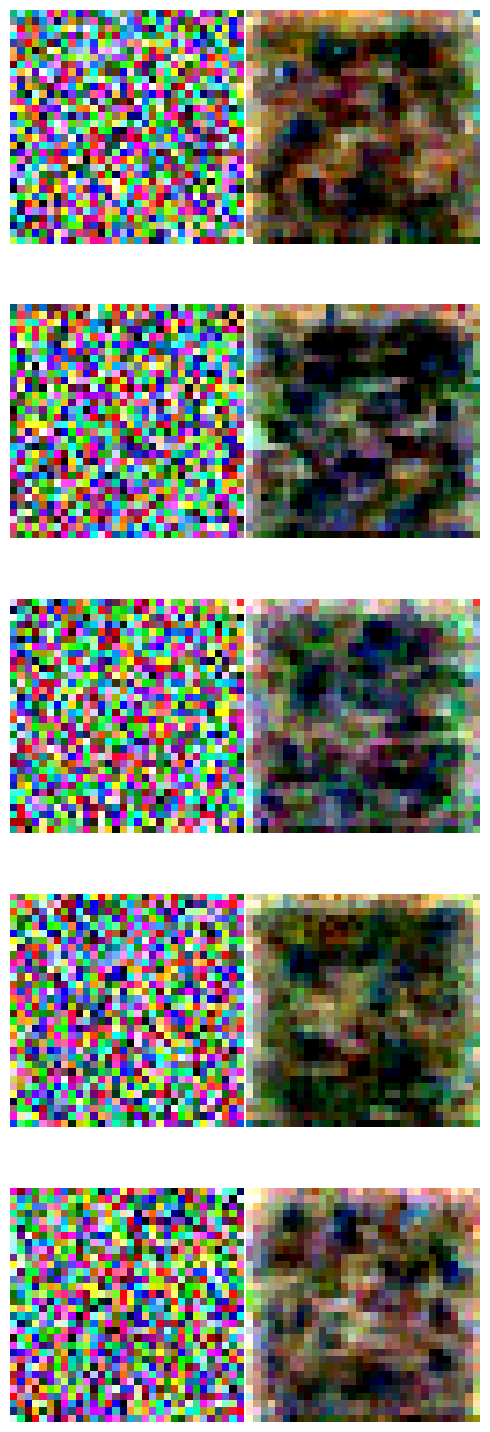

Epoch 9:   8%|▊         | 6/76 [00:10<02:04,  1.77s/it]

step: 690 losses: 0.1627710461616516 0.6358411312103271 0.0772913321852684


Epoch 9:  21%|██        | 16/76 [00:33<01:48,  1.82s/it]

step: 700 losses: 0.09580665081739426 0.6282596588134766 0.0904260128736496


Epoch 9:  34%|███▍      | 26/76 [00:54<01:29,  1.78s/it]

step: 710 losses: 0.0987289547920227 0.6422436237335205 0.10954486578702927


Epoch 9:  47%|████▋     | 36/76 [01:15<01:11,  1.79s/it]

step: 720 losses: 0.16470511257648468 0.6494812369346619 0.06246637925505638


Epoch 9:  61%|██████    | 46/76 [01:36<00:53,  1.79s/it]

step: 730 losses: 0.1777849644422531 0.6513614654541016 0.07383240759372711


Epoch 9:  74%|███████▎  | 56/76 [01:58<00:36,  1.80s/it]

step: 740 losses: 0.13439930975437164 0.6464238166809082 0.09766071289777756


Epoch 9:  87%|████████▋ | 66/76 [02:25<00:18,  1.86s/it]

step: 750 losses: 0.21850311756134033 0.6465693712234497 0.09852276742458344


Epoch 9: 100%|██████████| 76/76 [02:48<00:00,  2.22s/it]


<Figure size 640x480 with 0 Axes>

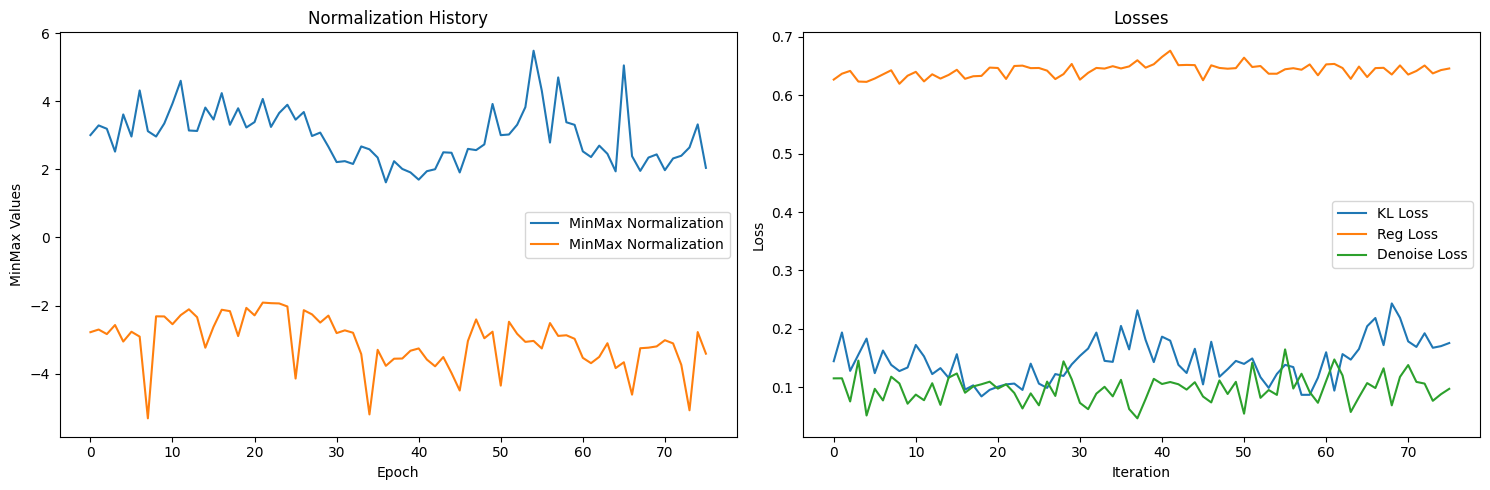

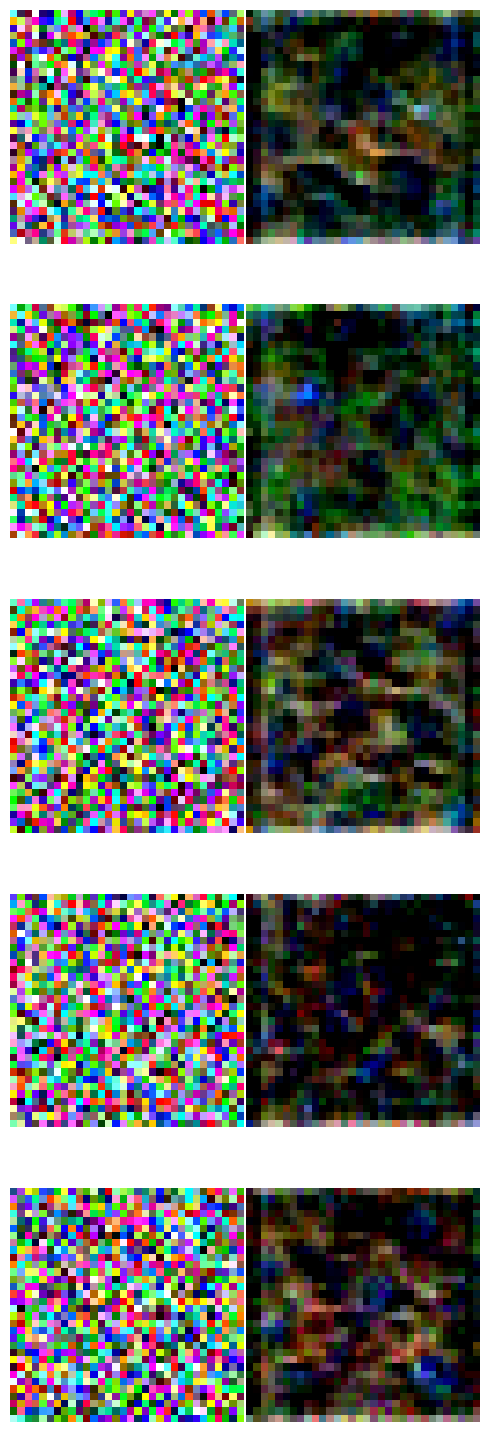

Finished training


<Figure size 640x480 with 0 Axes>

In [40]:
train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader)

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4158: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


step: 0 losses: 0.2100236862897873 0.6377878189086914 0.06349503993988037


Epoch 0:  13%|█▎        | 10/76 [00:21<01:56,  1.77s/it]

step: 10 losses: 0.15550372004508972 0.6385495066642761 0.10984453558921814


Epoch 0:  26%|██▋       | 20/76 [00:42<01:39,  1.78s/it]

step: 20 losses: 0.1456991732120514 0.6486663818359375 0.11716234683990479


Epoch 0:  39%|███▉      | 30/76 [01:05<01:24,  1.83s/it]

step: 30 losses: 0.16995558142662048 0.6346046924591064 0.10281559824943542


Epoch 0:  53%|█████▎    | 40/76 [01:31<01:06,  1.84s/it]

step: 40 losses: 0.14976489543914795 0.6326484084129333 0.10425304621458054


Epoch 0:  66%|██████▌   | 50/76 [01:53<00:46,  1.79s/it]

step: 50 losses: 0.13513785600662231 0.6366754770278931 0.16165365278720856


Epoch 0:  79%|███████▉  | 60/76 [02:13<00:28,  1.78s/it]

step: 60 losses: 0.12670044600963593 0.6333335638046265 0.0702105164527893


Epoch 0:  92%|█████████▏| 70/76 [02:37<00:10,  1.81s/it]

step: 70 losses: 0.17763642966747284 0.6338404417037964 0.12249993532896042


Epoch 0: 100%|██████████| 76/76 [02:52<00:00,  2.27s/it]


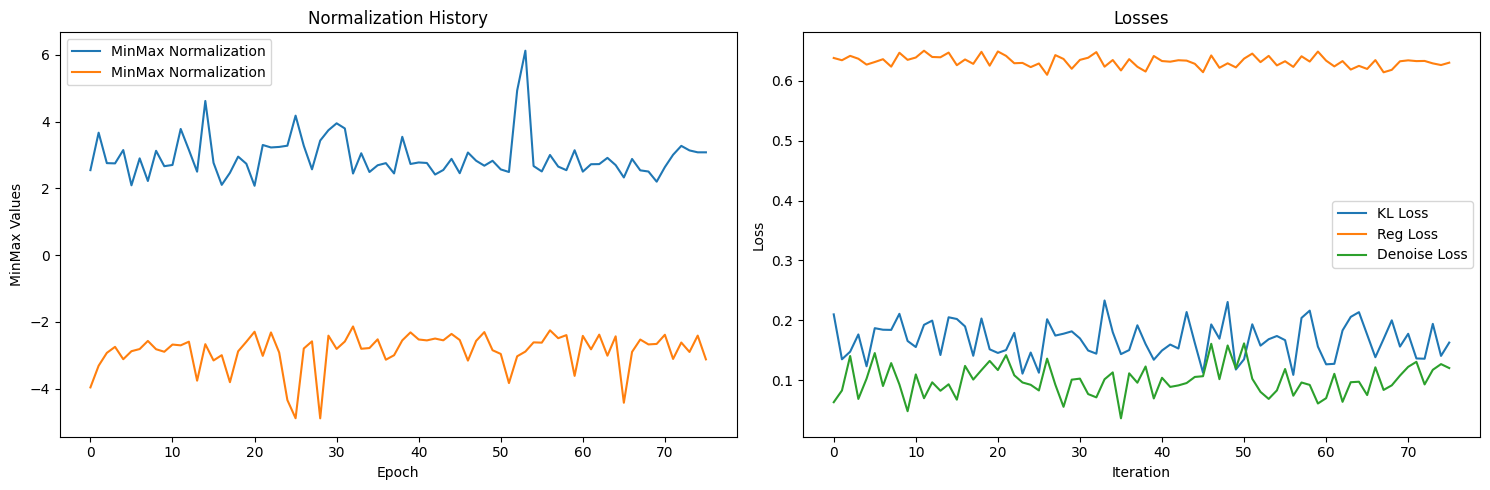

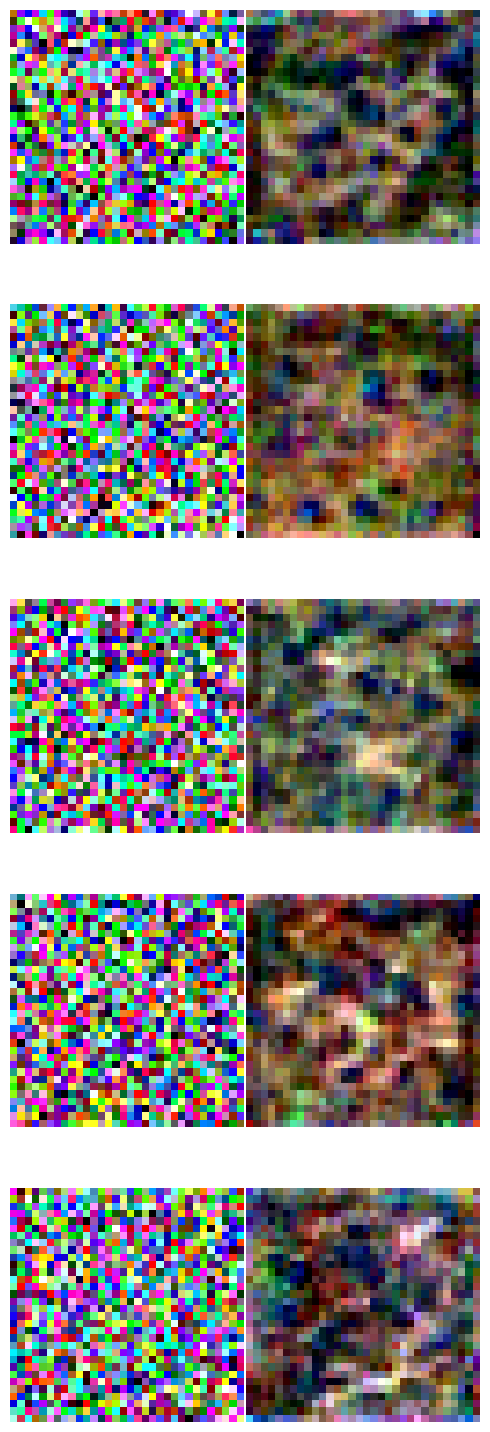

Epoch 1:   5%|▌         | 4/76 [00:07<02:11,  1.83s/it]

step: 80 losses: 0.15387685596942902 0.6315232515335083 0.10882916301488876


Epoch 1:  18%|█▊        | 14/76 [00:28<01:51,  1.79s/it]

step: 90 losses: 0.11662274599075317 0.6390012502670288 0.055633269250392914


Epoch 1:  32%|███▏      | 24/76 [00:49<01:32,  1.78s/it]

step: 100 losses: 0.16054822504520416 0.6180374622344971 0.04445929080247879


Epoch 1:  45%|████▍     | 34/76 [01:15<01:17,  1.84s/it]

step: 110 losses: 0.12373396009206772 0.6167069673538208 0.09489386528730392


Epoch 1:  58%|█████▊    | 44/76 [01:38<00:58,  1.81s/it]

step: 120 losses: 0.1673627346754074 0.6265923380851746 0.10171730816364288


Epoch 1:  71%|███████   | 54/76 [01:59<00:39,  1.79s/it]

step: 130 losses: 0.1441051959991455 0.6360803246498108 0.1167849451303482


Epoch 1:  84%|████████▍ | 64/76 [02:20<00:21,  1.78s/it]

step: 140 losses: 0.14243219792842865 0.6254668235778809 0.08017309010028839


Epoch 1:  97%|█████████▋| 74/76 [02:41<00:03,  1.78s/it]

step: 150 losses: 0.1820208728313446 0.6219935417175293 0.05815167725086212


Epoch 1: 100%|██████████| 76/76 [02:48<00:00,  2.22s/it]


<Figure size 640x480 with 0 Axes>

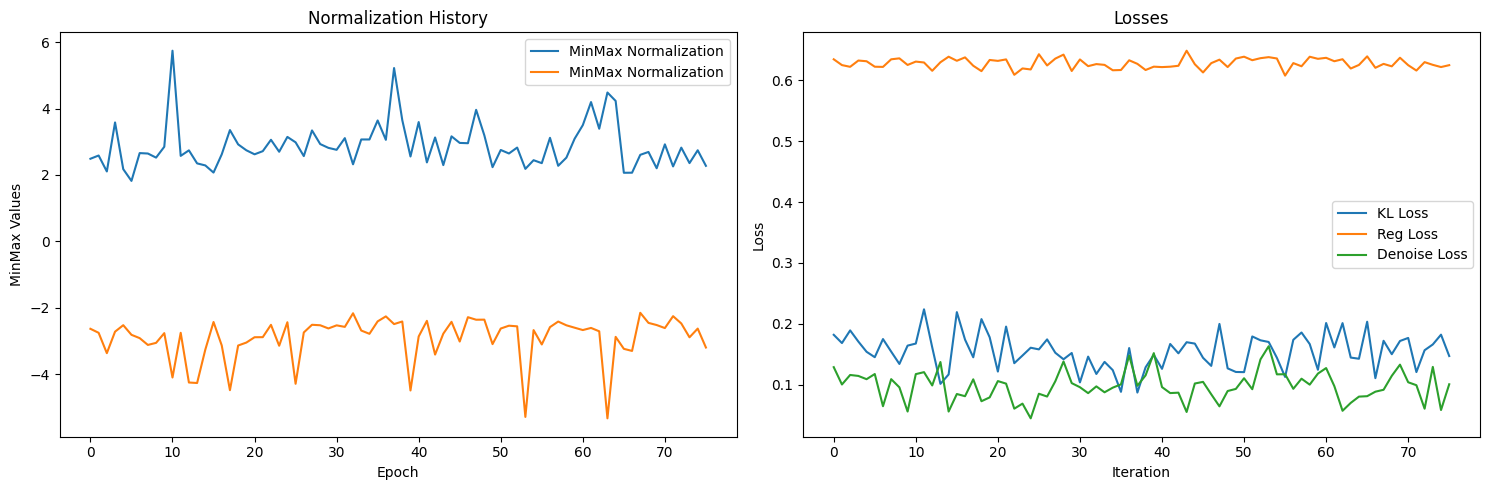

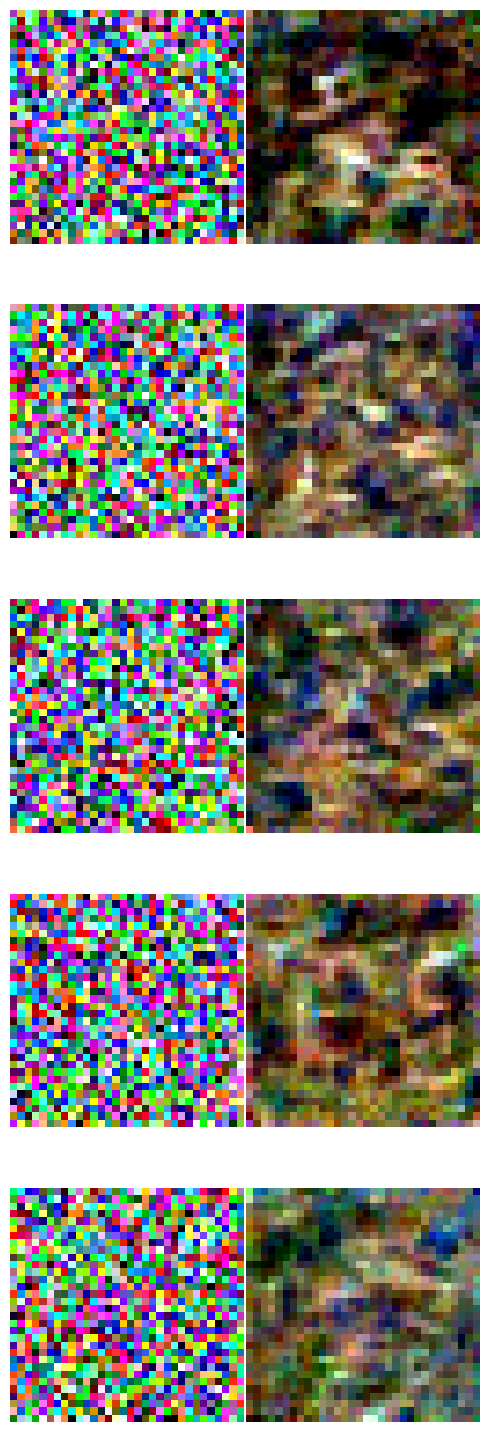

Epoch 2:  11%|█         | 8/76 [00:14<01:58,  1.75s/it]

step: 160 losses: 0.11226798593997955 0.6060917973518372 0.1189584955573082


Epoch 2:  24%|██▎       | 18/76 [00:35<01:43,  1.79s/it]

step: 170 losses: 0.15665203332901 0.6293445825576782 0.11853082478046417


Epoch 2:  37%|███▋      | 28/76 [01:01<01:28,  1.84s/it]

step: 180 losses: 0.10526542365550995 0.6173965930938721 0.08595089614391327


Epoch 2:  50%|█████     | 38/76 [01:21<01:07,  1.79s/it]

step: 190 losses: 0.11201141774654388 0.6363430619239807 0.08638646453619003


Epoch 2:  63%|██████▎   | 48/76 [01:42<00:49,  1.78s/it]

step: 200 losses: 0.12428605556488037 0.6282156109809875 0.10316920280456543


Epoch 2:  76%|███████▋  | 58/76 [02:04<00:32,  1.80s/it]

step: 210 losses: 0.15552064776420593 0.6292968988418579 0.10239215940237045


Epoch 2:  89%|████████▉ | 68/76 [02:25<00:14,  1.78s/it]

step: 220 losses: 0.12141172587871552 0.6226369738578796 0.09219186007976532


Epoch 2: 100%|██████████| 76/76 [02:43<00:00,  2.15s/it]


<Figure size 640x480 with 0 Axes>

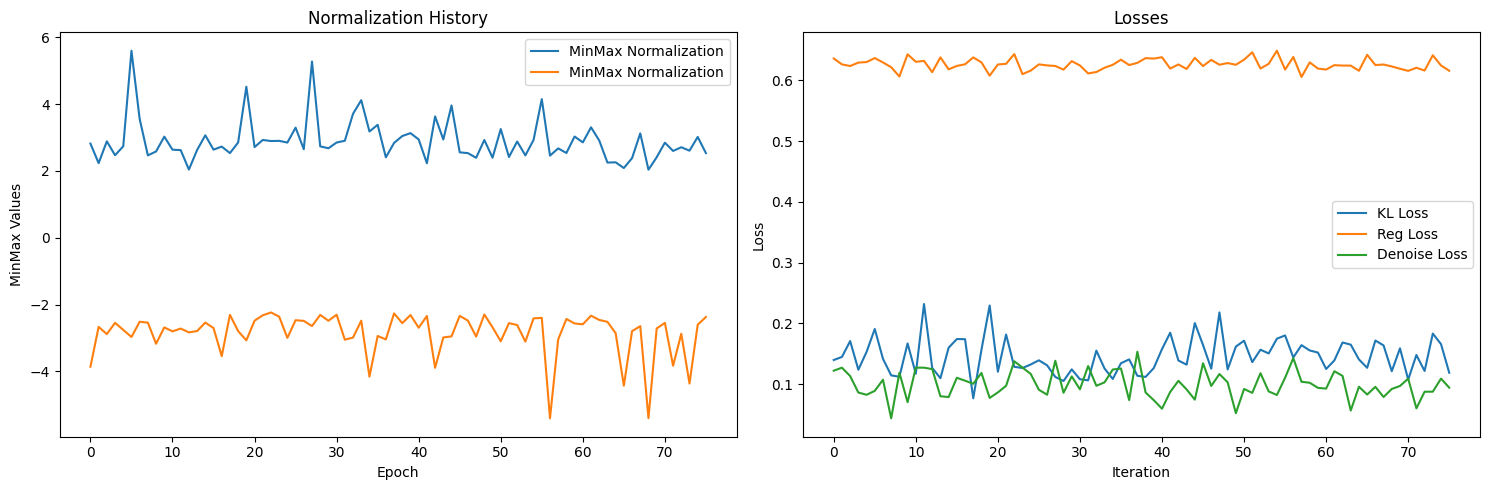

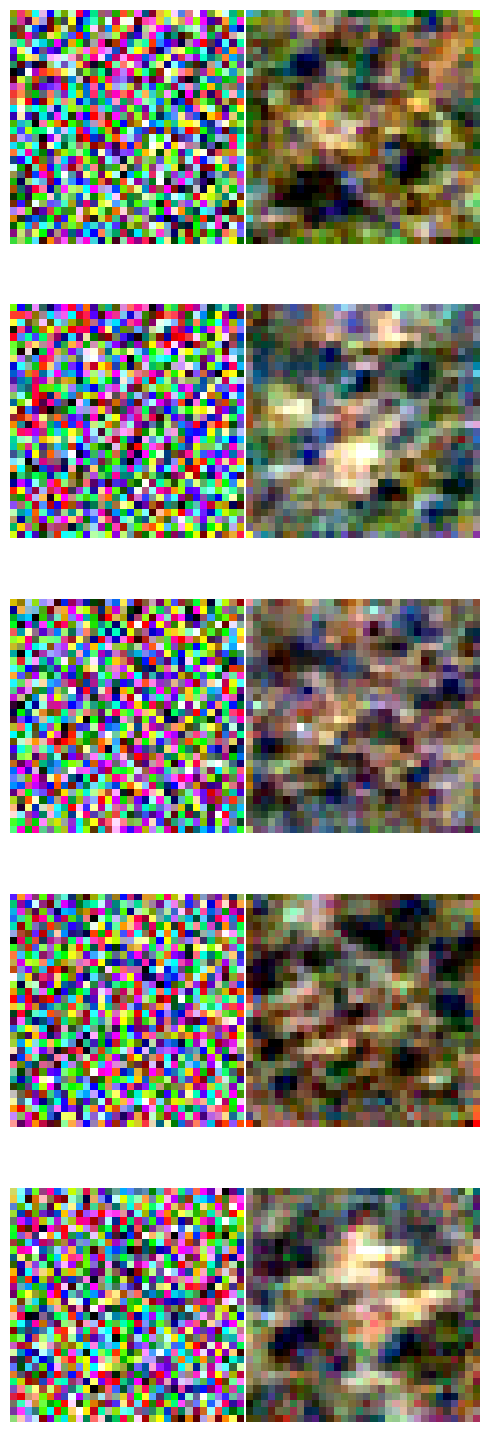

Epoch 3:   3%|▎         | 2/76 [00:03<02:23,  1.94s/it]

step: 230 losses: 0.1964734047651291 0.6271162033081055 0.10661536455154419


Epoch 3:  16%|█▌        | 12/76 [00:25<01:54,  1.79s/it]

step: 240 losses: 0.1456376016139984 0.625807523727417 0.11410292237997055


Epoch 3:  29%|██▉       | 22/76 [00:46<01:36,  1.78s/it]

step: 250 losses: 0.13911432027816772 0.633754312992096 0.11197508871555328


Epoch 3:  42%|████▏     | 32/76 [01:07<01:18,  1.79s/it]

step: 260 losses: 0.14219683408737183 0.6233085989952087 0.09603597223758698


Epoch 3:  55%|█████▌    | 42/76 [01:29<01:00,  1.78s/it]

step: 270 losses: 0.14470073580741882 0.6210713386535645 0.09961184859275818


Epoch 3:  68%|██████▊   | 52/76 [01:50<00:42,  1.78s/it]

step: 280 losses: 0.16608856618404388 0.6195753812789917 0.14366766810417175


Epoch 3:  82%|████████▏ | 62/76 [02:11<00:24,  1.78s/it]

step: 290 losses: 0.1746075600385666 0.6277165412902832 0.0749569684267044


Epoch 3:  95%|█████████▍| 72/76 [02:32<00:07,  1.79s/it]

step: 300 losses: 0.09697195142507553 0.6174556016921997 0.08230532705783844


Epoch 3: 100%|██████████| 76/76 [02:44<00:00,  2.16s/it]


<Figure size 640x480 with 0 Axes>

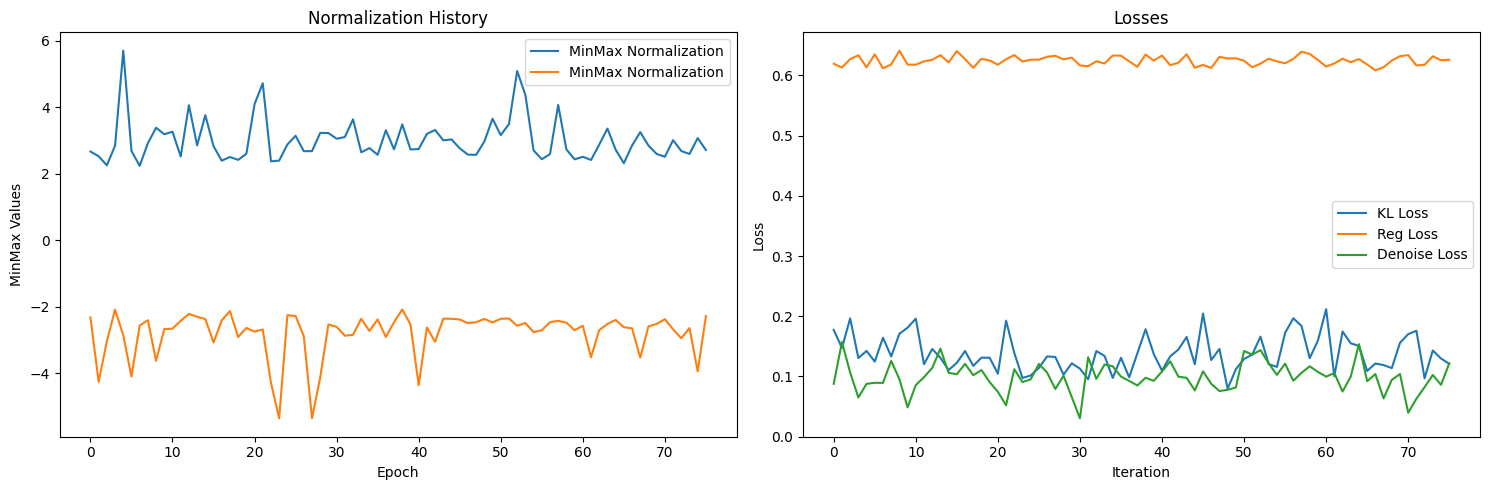

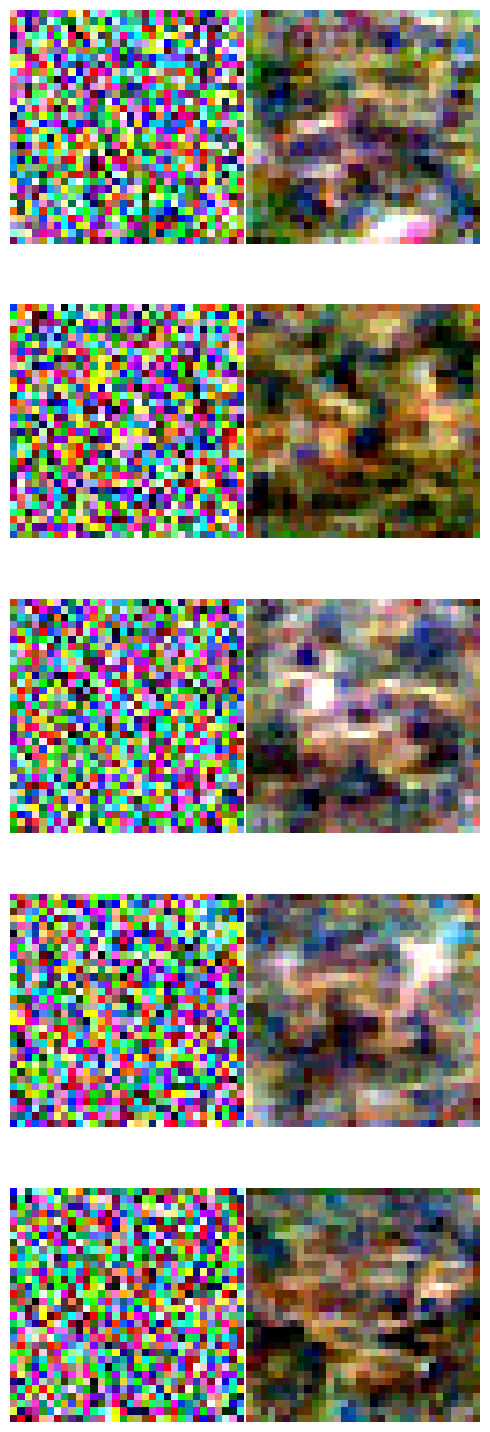

Epoch 4:   8%|▊         | 6/76 [00:10<02:03,  1.76s/it]

step: 310 losses: 0.17462441325187683 0.6213324069976807 0.06913015246391296


Epoch 4:  21%|██        | 16/76 [00:31<01:47,  1.79s/it]

step: 320 losses: 0.12978868186473846 0.6249172687530518 0.06429767608642578


Epoch 4:  34%|███▍      | 26/76 [00:52<01:29,  1.79s/it]

step: 330 losses: 0.15027479827404022 0.6317949295043945 0.12037181854248047


Epoch 4:  47%|████▋     | 36/76 [01:15<01:12,  1.81s/it]

step: 340 losses: 0.1544409692287445 0.633813738822937 0.06842727214097977


Epoch 4:  61%|██████    | 46/76 [01:36<00:53,  1.79s/it]

step: 350 losses: 0.09039632976055145 0.630391538143158 0.08516187965869904


Epoch 4:  74%|███████▎  | 56/76 [02:01<00:36,  1.82s/it]

step: 360 losses: 0.17046789824962616 0.6332246661186218 0.1356748342514038


Epoch 4:  87%|████████▋ | 66/76 [02:22<00:17,  1.79s/it]

step: 370 losses: 0.15582998096942902 0.6242059469223022 0.08849391341209412


Epoch 4: 100%|██████████| 76/76 [02:43<00:00,  2.15s/it]


<Figure size 640x480 with 0 Axes>

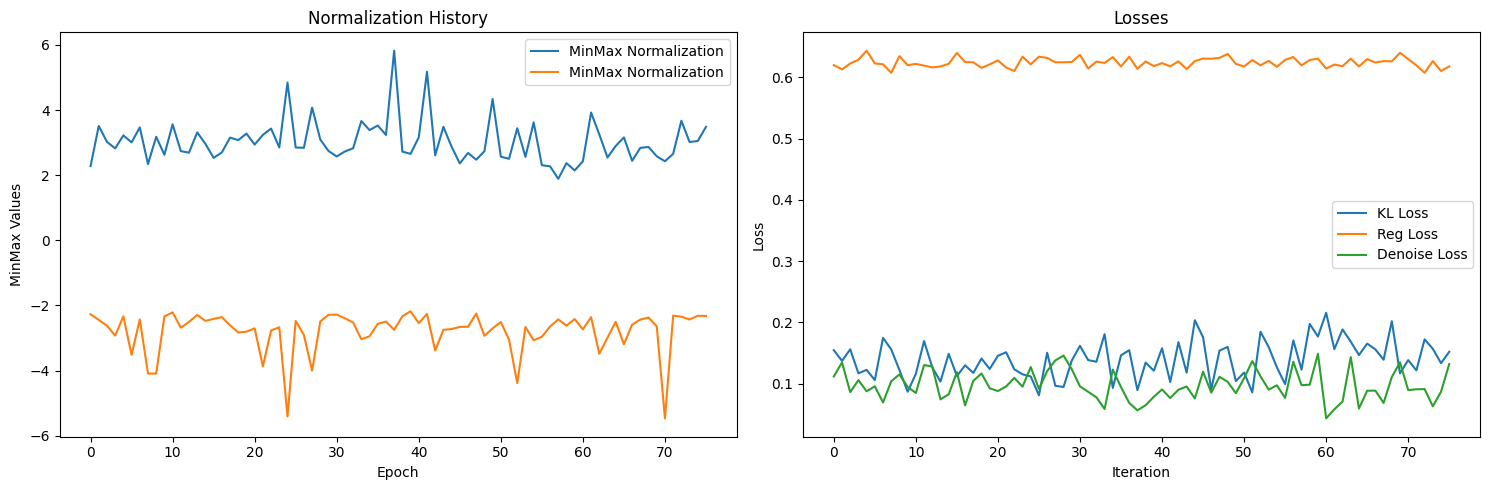

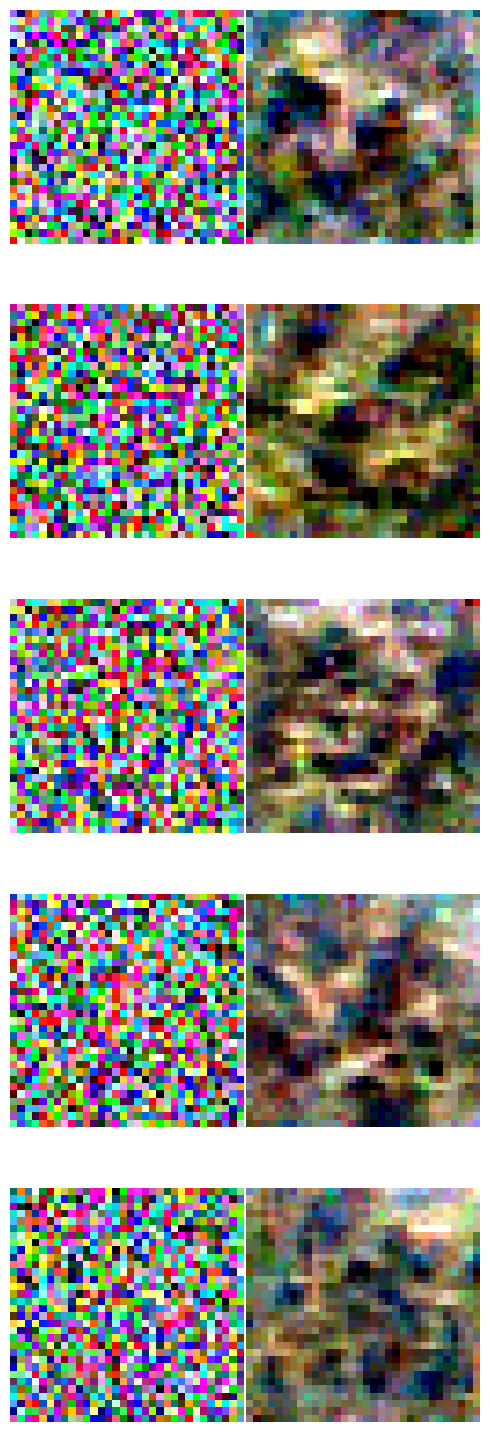

Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

step: 380 losses: 0.1349145770072937 0.6262468099594116 0.11191924661397934


Epoch 5:  13%|█▎        | 10/76 [00:21<01:58,  1.79s/it]

step: 390 losses: 0.1153854951262474 0.6205201148986816 0.07185682654380798


Epoch 5:  26%|██▋       | 20/76 [00:45<01:42,  1.83s/it]

step: 400 losses: 0.10555975139141083 0.6324431896209717 0.09668610990047455


Epoch 5:  39%|███▉      | 30/76 [01:09<01:23,  1.83s/it]

step: 410 losses: 0.12180539965629578 0.6161103248596191 0.11747052520513535


Epoch 5:  53%|█████▎    | 40/76 [01:31<01:04,  1.80s/it]

step: 420 losses: 0.14364245533943176 0.630783200263977 0.11030228435993195


Epoch 5:  66%|██████▌   | 50/76 [01:52<00:46,  1.78s/it]

step: 430 losses: 0.15262804925441742 0.6176549792289734 0.06888268142938614


Epoch 5:  79%|███████▉  | 60/76 [02:16<00:29,  1.82s/it]

step: 440 losses: 0.15740135312080383 0.6289485692977905 0.07301254570484161


Epoch 5:  92%|█████████▏| 70/76 [02:37<00:10,  1.81s/it]

step: 450 losses: 0.09929050505161285 0.623604416847229 0.14791439473628998


Epoch 5: 100%|██████████| 76/76 [02:52<00:00,  2.26s/it]


<Figure size 640x480 with 0 Axes>

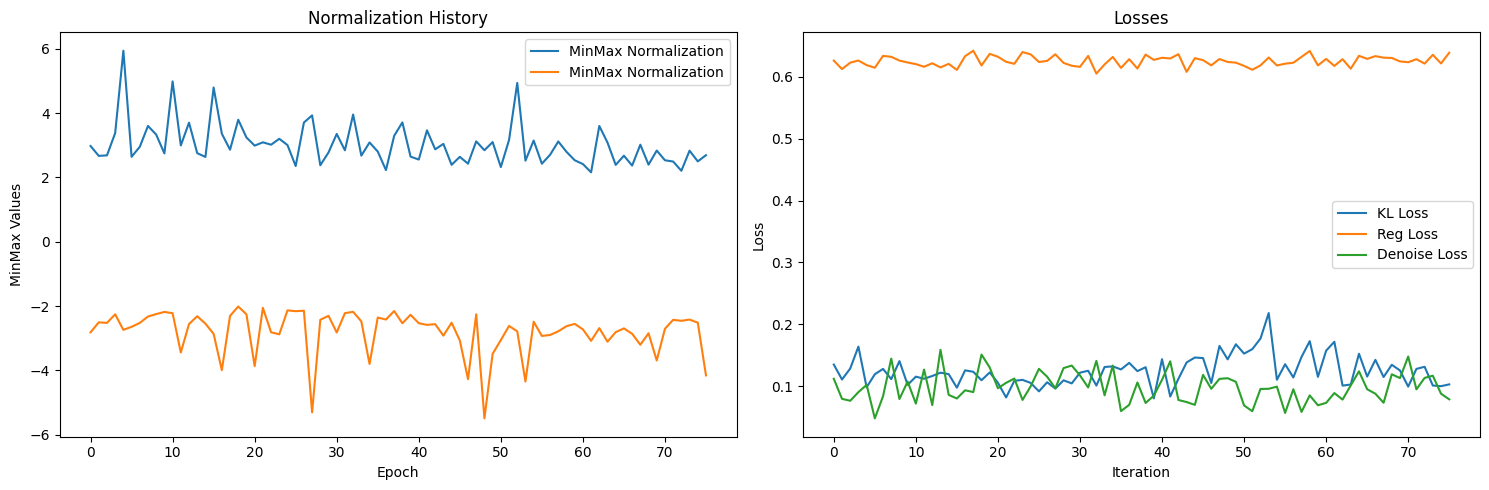

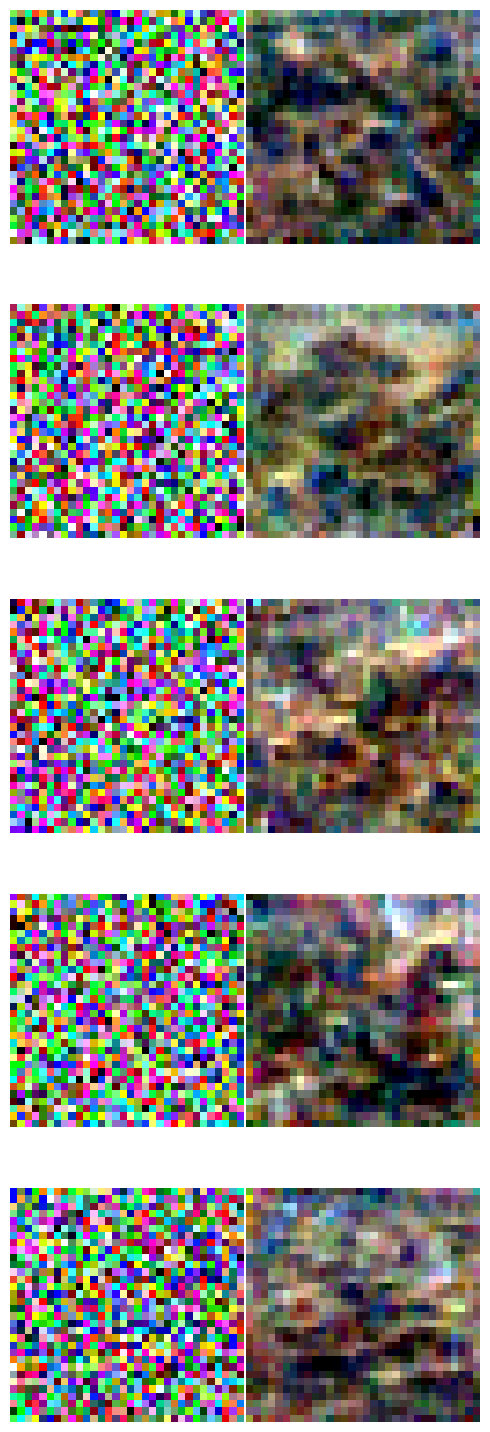

Epoch 6:   5%|▌         | 4/76 [00:07<02:09,  1.81s/it]

step: 460 losses: 0.11714987456798553 0.6173774003982544 0.09973301738500595


Epoch 6:  18%|█▊        | 14/76 [00:28<01:51,  1.80s/it]

step: 470 losses: 0.11916752904653549 0.626757025718689 0.045625269412994385


Epoch 6:  32%|███▏      | 24/76 [00:49<01:32,  1.78s/it]

step: 480 losses: 0.11883409321308136 0.6208786368370056 0.12109263241291046


Epoch 6:  45%|████▍     | 34/76 [01:13<01:15,  1.81s/it]

step: 490 losses: 0.11358712613582611 0.6138044595718384 0.10496523231267929


Epoch 6:  58%|█████▊    | 44/76 [01:34<00:57,  1.80s/it]

step: 500 losses: 0.15804070234298706 0.6375721096992493 0.1210521012544632


Epoch 6:  71%|███████   | 54/76 [01:55<00:39,  1.78s/it]

step: 510 losses: 0.10301753133535385 0.637531042098999 0.12085264921188354


Epoch 6:  84%|████████▍ | 64/76 [02:19<00:21,  1.81s/it]

step: 520 losses: 0.14483380317687988 0.6146567463874817 0.11721350252628326


Epoch 6:  97%|█████████▋| 74/76 [02:41<00:03,  1.80s/it]

step: 530 losses: 0.11140769720077515 0.6177850961685181 0.09735056012868881


Epoch 6: 100%|██████████| 76/76 [02:48<00:00,  2.22s/it]


<Figure size 640x480 with 0 Axes>

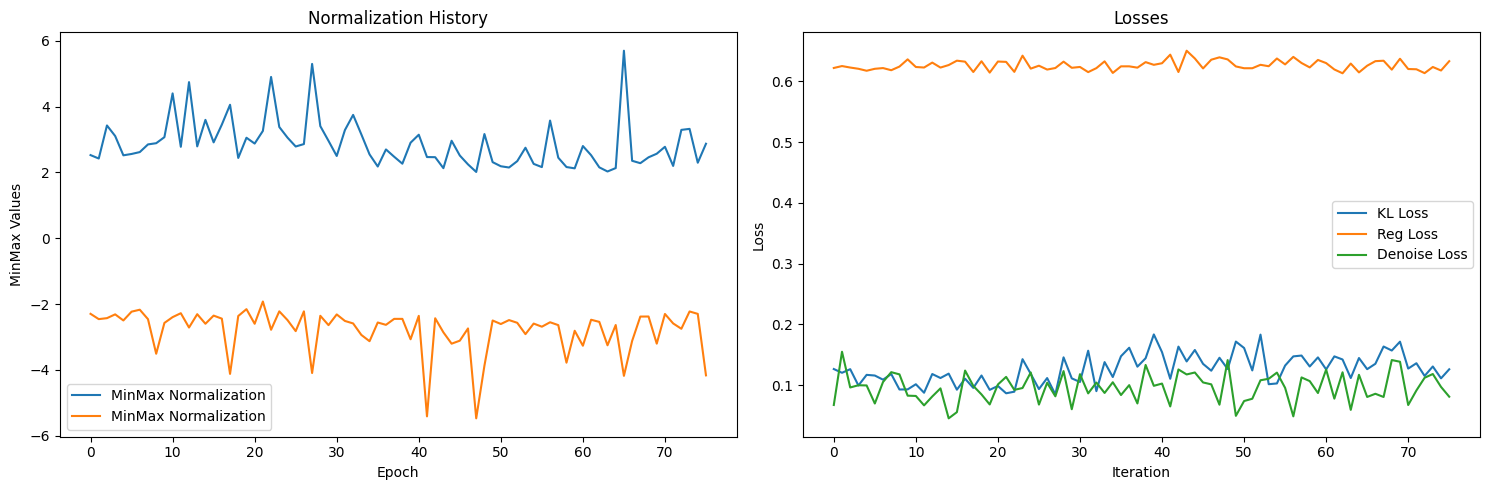

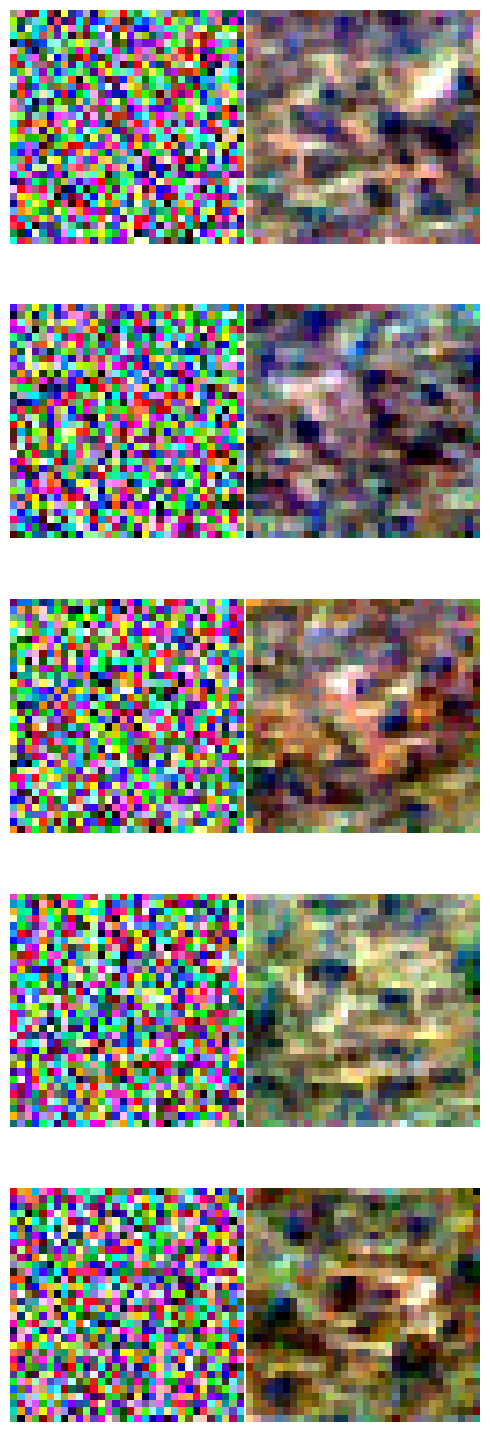

Epoch 7:  11%|█         | 8/76 [00:14<02:00,  1.77s/it]

step: 540 losses: 0.10788377374410629 0.6371803879737854 0.06789505481719971


Epoch 7:  24%|██▎       | 18/76 [00:35<01:43,  1.79s/it]

step: 550 losses: 0.10006259381771088 0.6370259523391724 0.07337507605552673


Epoch 7:  37%|███▋      | 28/76 [00:57<01:26,  1.80s/it]

step: 560 losses: 0.11922113597393036 0.6122922301292419 0.06166088208556175


Epoch 7:  50%|█████     | 38/76 [01:18<01:07,  1.78s/it]

step: 570 losses: 0.12811867892742157 0.6240134835243225 0.11192333698272705


Epoch 7:  63%|██████▎   | 48/76 [01:40<00:50,  1.80s/it]

step: 580 losses: 0.13761141896247864 0.6237227916717529 0.06039954349398613


Epoch 7:  76%|███████▋  | 58/76 [02:01<00:32,  1.80s/it]

step: 590 losses: 0.1404828131198883 0.6410664916038513 0.08719699084758759


Epoch 7:  89%|████████▉ | 68/76 [02:22<00:14,  1.78s/it]

step: 600 losses: 0.10278188437223434 0.6186230182647705 0.0870332345366478


Epoch 7: 100%|██████████| 76/76 [02:40<00:00,  2.11s/it]


<Figure size 640x480 with 0 Axes>

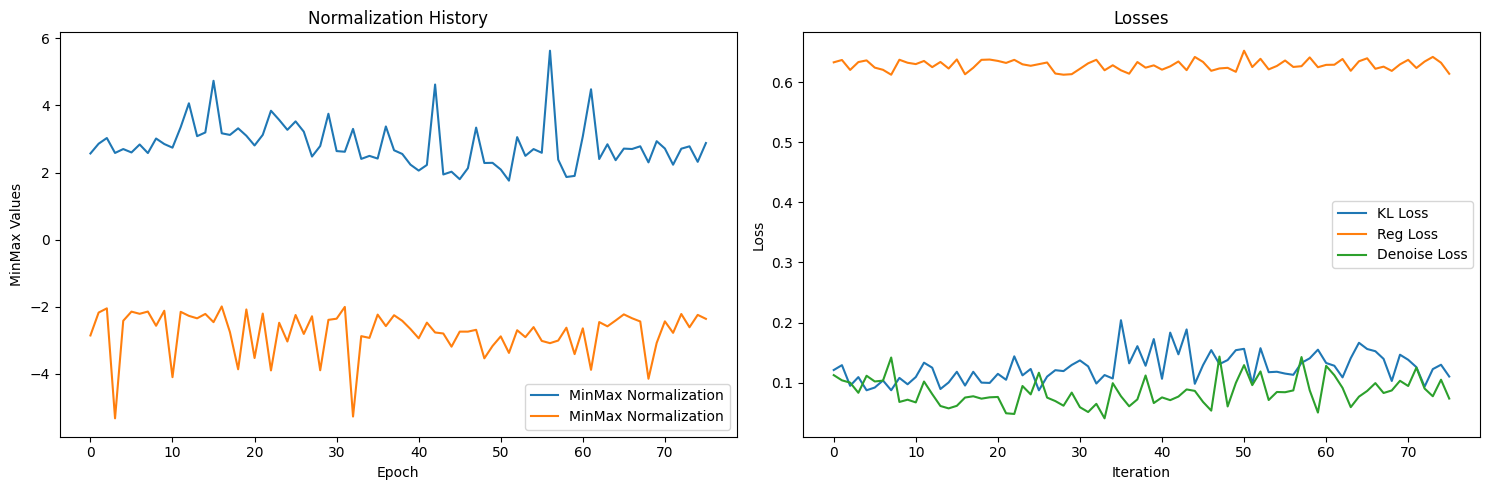

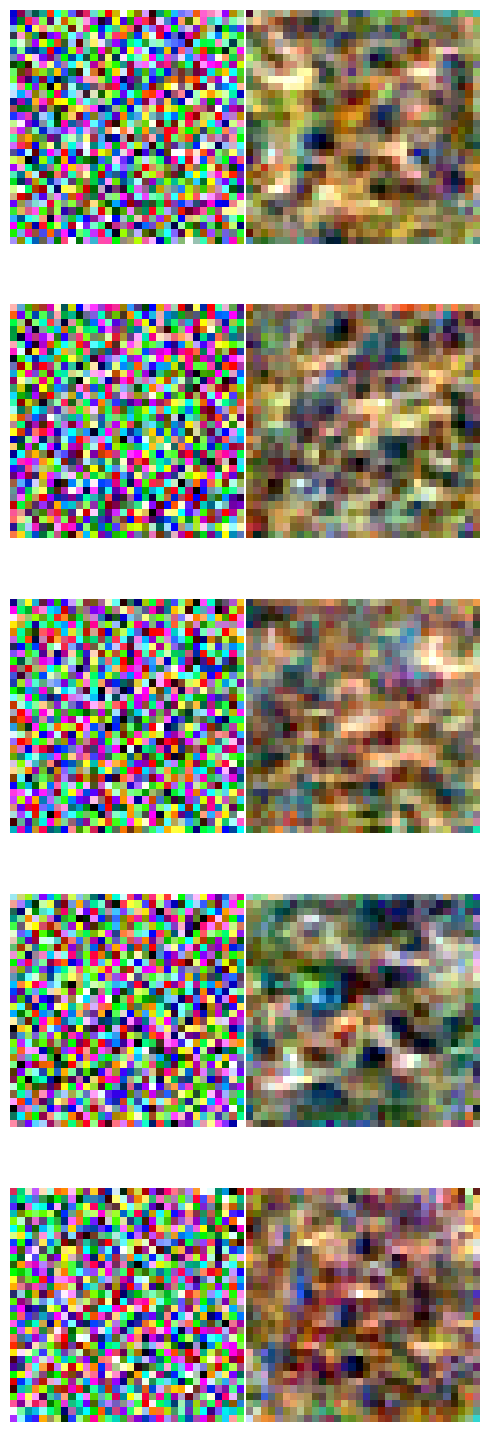

Epoch 8:   3%|▎         | 2/76 [00:04<02:25,  1.96s/it]

step: 610 losses: 0.12892526388168335 0.6173112988471985 0.10993452370166779


Epoch 8:  16%|█▌        | 12/76 [00:29<01:58,  1.84s/it]

step: 620 losses: 0.10306265205144882 0.6314947605133057 0.0776132196187973


Epoch 8:  29%|██▉       | 22/76 [00:50<01:37,  1.80s/it]

step: 630 losses: 0.13481122255325317 0.621864378452301 0.10152708739042282


Epoch 8:  42%|████▏     | 32/76 [01:12<01:18,  1.79s/it]

step: 640 losses: 0.1494886577129364 0.6333031058311462 0.05603386089205742


Epoch 8:  55%|█████▌    | 42/76 [01:33<01:01,  1.80s/it]

step: 650 losses: 0.1632324457168579 0.6254386901855469 0.10935862362384796


Epoch 8:  68%|██████▊   | 52/76 [01:54<00:42,  1.79s/it]

step: 660 losses: 0.12097126245498657 0.6384721398353577 0.11096544563770294


Epoch 8:  82%|████████▏ | 62/76 [02:17<00:25,  1.81s/it]

step: 670 losses: 0.13083390891551971 0.6309841275215149 0.0430607907474041


Epoch 8:  95%|█████████▍| 72/76 [02:39<00:07,  1.80s/it]

step: 680 losses: 0.142938032746315 0.6296475529670715 0.11087451875209808


Epoch 8: 100%|██████████| 76/76 [02:50<00:00,  2.24s/it]


<Figure size 640x480 with 0 Axes>

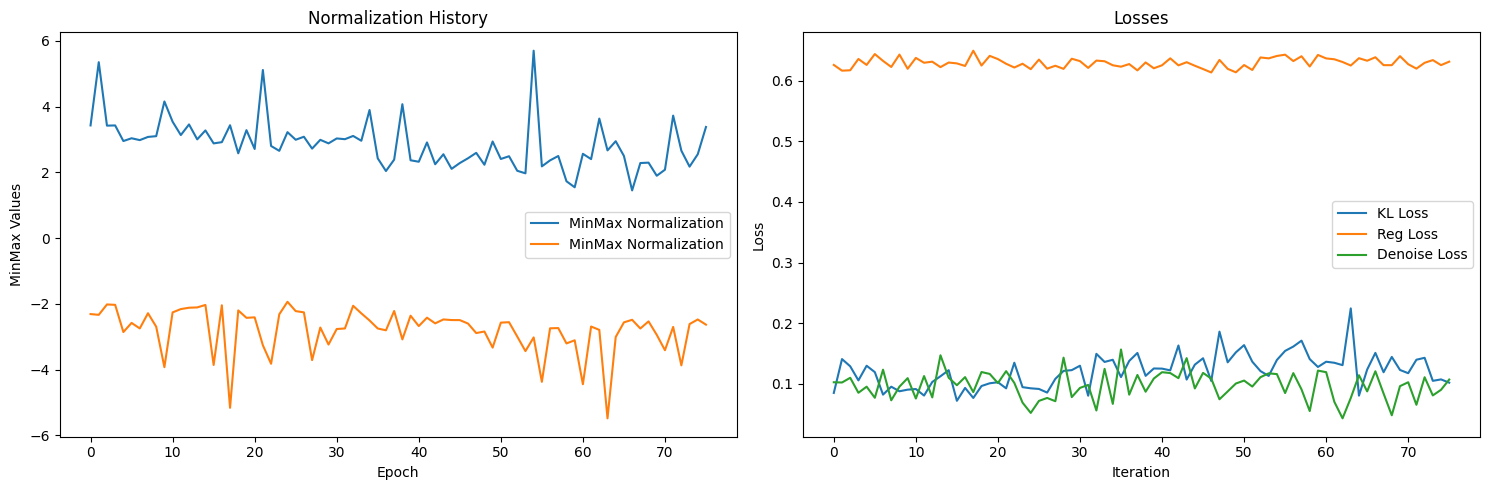

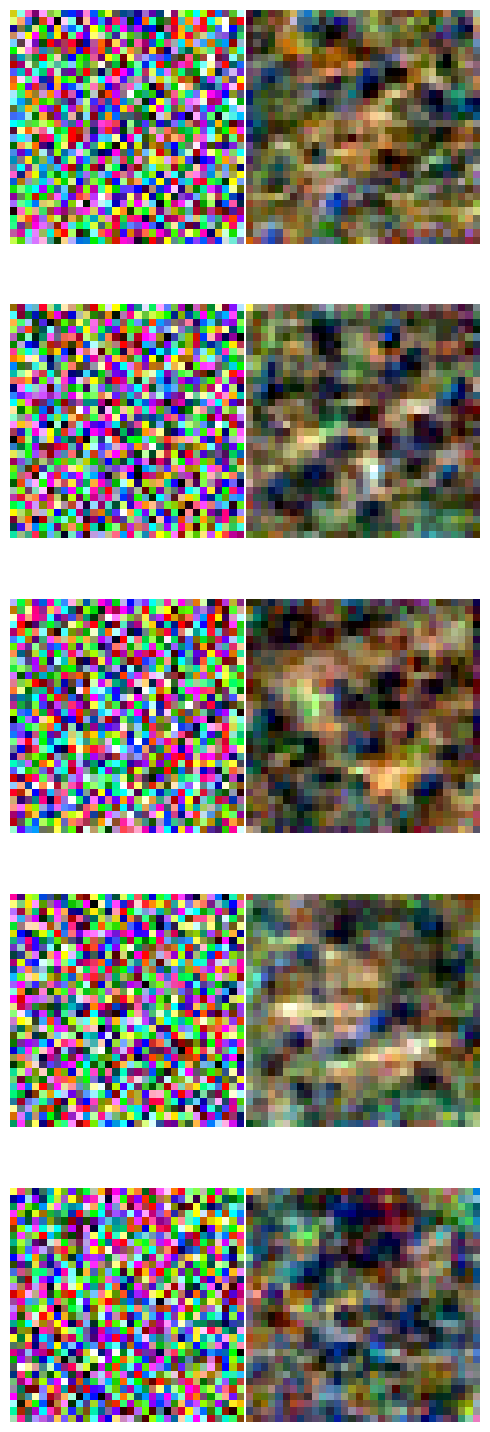

Epoch 9:   8%|▊         | 6/76 [00:11<02:04,  1.77s/it]

step: 690 losses: 0.09018878638744354 0.6190484762191772 0.04330068826675415


Epoch 9:  21%|██        | 16/76 [00:32<01:47,  1.79s/it]

step: 700 losses: 0.09941248595714569 0.649305522441864 0.11813808977603912


Epoch 9:  34%|███▍      | 26/76 [00:54<01:30,  1.81s/it]

step: 710 losses: 0.0703430026769638 0.6269820332527161 0.07602758705615997


Epoch 9:  47%|████▋     | 36/76 [01:18<01:12,  1.82s/it]

step: 720 losses: 0.09237603843212128 0.639235258102417 0.11001928895711899


Epoch 9:  61%|██████    | 46/76 [01:39<00:53,  1.78s/it]

step: 730 losses: 0.10542389750480652 0.620851993560791 0.09759246557950974


Epoch 9:  74%|███████▎  | 56/76 [02:00<00:35,  1.79s/it]

step: 740 losses: 0.15364275872707367 0.6411657333374023 0.09614288806915283


Epoch 9:  87%|████████▋ | 66/76 [02:21<00:17,  1.78s/it]

step: 750 losses: 0.12137971818447113 0.632646918296814 0.09998643398284912


Epoch 9: 100%|██████████| 76/76 [02:43<00:00,  2.15s/it]


<Figure size 640x480 with 0 Axes>

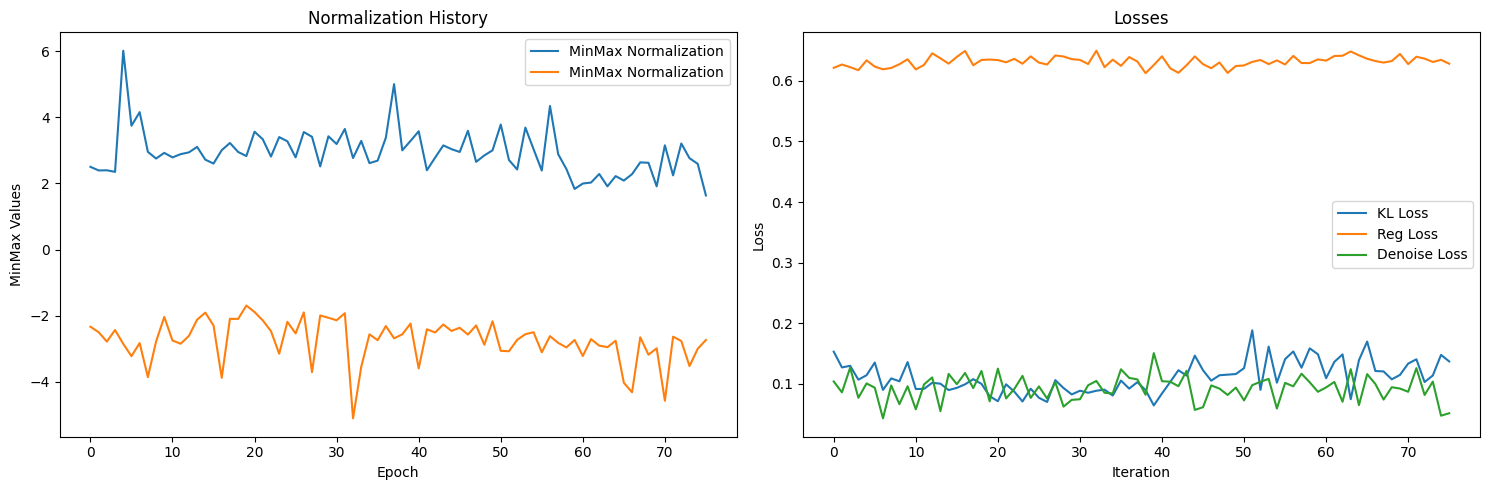

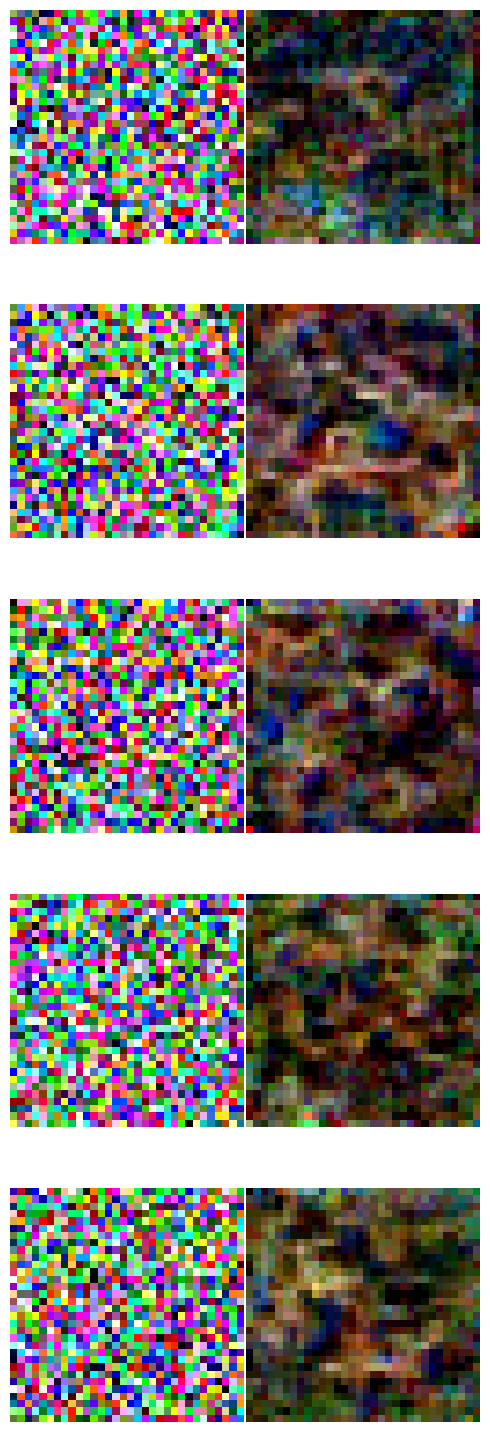

Finished training


<Figure size 640x480 with 0 Axes>

In [42]:
args.lr_netG=1e-6
args.lr_mu_fake=1e-6
train(args, forward_diffusion, mu_real, mu_fake, netG, ref_loader)

#### test

In [13]:
import gdown

url = 'https://drive.google.com/uc?id=12sF62JWpRqUdYMTuJkFT6sItsE8-BJQV'
output_path = args.pretrained_weights
gdown.download(url, output_path, quiet=True)

'/content/model_pretrained.pth'

In [ ]:
args = parser.parse_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load("/content/diff_dist_cifar/data.pkl", map_location=device)

hugging_face_id = "google/ddpm-cifar10-32"
pretrained_unet = UNet2DModel.from_pretrained(hugging_face_id)
scheduler = DDPMScheduler.from_config(hugging_face_id)
scheduler_params = scheduler.config
imahe_shape = (pretrained_unet.config.in_channels, pretrained_unet.config.sample_size, pretrained_unet.config.sample_size)

netG = DDPM(
    network=pretrained_unet,
    device=device,
    image_chw=imahe_shape,
    scheduler_params=scheduler_params
)
netG.load_state_dict(checkpoint)
netG_old = netG

In [ ]:
#s=10
#netG_old.to(device)
#with torch.no_grad():
#  image, _ = netG_old.sample(s, (3, 32, 32), device)

In [ ]:
torch.save(netG.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ddpm_celeb_1000.pth')